# Air Quality in Houston - Step 4: Modeling #



### Table of Contents

  *  [4.0. So Many Models, So Little Time](#section4_0)

  *  [4.1. Indoor vs. Outdoor (RIOPA)](#section4_1)

     * [4.1.1. Linear Regression - sklearn & statsmodel:](#section4_1_1)

     * [4.1.2. Multiple Linear Regression:](#section4_1_2)
  
     * [4.1.3. SVR with RBF Kernel](#section4_1_3)
  
     * [4.1.4. Multiclass Logistic Regression:](#section4_1_4)
     
     * [4.1.5. K Nearest Neighbors:](#section4_1_5)
     
     * [4.1.6. SVM with RBF Kernel:](#section4_1_6)

     * [4.1.7. XGBoost for Classification:](#section4_1_7)

     * [4.1.8. XGBoost for Regression:](#section4_1_8)
     
     * [4.1.9. Riopa's Model:](#section4_1_9 )

  *  [4.2. Outdoor Air Quality (TECQ/EPA)](#section4_2)
         
  *  [4.3. Ozone Formation with XGBoost Regression](#section4_3)

  *  [4.4. Conclusion](#section4_4)


<a class="anchor" id="section4_0"></a>
## 4.0. So Many Models, So Little Time
The project consists in two parts:
-the modeling of indoor vs. outdoor (RIOPA) data which aims to predict indoor PM 2.5 concentrations from outdoor PM 2.5 concentrations, ambient data, weather data, and land use. 
-the modeling of outdoor air quality which aims to predict air quality in Houston in 2028 taking into account 6 majors pollutants (i.e. ozone, CO, NO2, SO2, PM 2.5, PM 10), population growth, increase in traffic, land use, and variation in climate.
As the data is a mix of numerical and categorical data types, regression and classification models can be tried out. The following models will be tested in this notebook:
- Linear Regression with sklearn linear_model.
- Linear Regression with statsmodel OLS.
- Multilinear Regresssion with statsmodel OLS.
- Support Vector Regression using RBF kernel with sklearn SVR.
- Support Vector Machine using RBF kernel with sklearn SVM.
- Multiclass Logistic Regression with sklearn LogisticRegression.
- K Nearest Neighbor with sklearn KNeighborsClassifier.
- Extreme Gradient Boosting with XGBoost [https://xgboost.readthedocs.io/en/latest/]

For the modeling of the outdoor air quality train/test sets where the pollutants concentrations were transformed into AQI categories (i.e. safe, moderate, unhealthy), only the following classification models will be tried out:
- Logistic Regression with sklearn LogisticRegression.
- Support Vector Machine using RBF kernel with sklearn SVM.
- Extreme Gradient Boosting with XGBoost [https://xgboost.readthedocs.io/en/latest/]

All needed items that were created in 03_Feature cannot be imported because it is not practical (i.e. too long/large/time consuming). I'll be importing the clean dataframes and scale/split as needed. The code to import all saved features can be found under '4.3. Annex'.
The clean dataframes and train/test files are being imported from the folder "03_Feature".

In [415]:
### Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pylab as pl
from IPython.display import Image
import seaborn as sns
import copy
import pickle
import math
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, learning_curve, KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, SCORERS, r2_score, accuracy_score,label_ranking_average_precision_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
#import AQI_Toolbox
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
from sklearn.svm import SVR, SVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_StuffAndThings\\'
path_demog='CP2_AQ_HOUSTON\\00_OriginalData\\DEMOG\\'
path_eda='CP2_AQ_HOUSTON\\02_EDA\\'
path_feat='CP2_AQ_HOUSTON\\03_Feature\\'
path_mod='CP2_AQ_HOUSTON\\04_Modeling\\'

In [416]:
### import aqitoolbox
### disabled until final version
# %run ./aqitoolbox.ipynb
# import aqitoolboc

In [417]:
### Create a dictionary of  the clean dataframes so that I know where to find
### the material I need without having to endlessly scroll up and down.

### empty dictionary that will contain filenames and dataframes ###
feat_files = {}
path_len=len(path_header+path_feat)
file_extension=len('.csv')

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_feat+'feat_*.csv')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_csv(filename,index_col=0)
    filename=filename[path_len::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-file_extension)]
    key_name = str(filename)    
    feat_files[key_name] = copy.deepcopy(df)

### dico_df is ready
### the key is the name of the df
### the value is the df itself
print(feat_files.keys())

dict_keys(['feat_aqi_co', 'feat_aqi_fivepoll', 'feat_aqi_no2', 'feat_aqi_ozno2poll', 'feat_aqi_ozone', 'feat_aqi_pm10', 'feat_aqi_pm25', 'feat_aqi_so2', 'feat_co', 'feat_fivepoll', 'feat_no2', 'feat_ozno2poll', 'feat_ozone', 'feat_pm10', 'feat_pm25', 'feat_riopa', 'feat_riopa_all', 'feat_riopa_aqi', 'feat_so2'])


In [418]:
### Let's unwrap all df with the correct name
for k,v in feat_files.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
feat_ozone.head()

,ozone,temp_max,dust_sand,rain_prcp,smoke_haze,thunder,fog_all,snow_all,rain_all,wind_avgspeed,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,39.0,57,0,0.0,0,0,0,0,0,21.03,...,0,0,0,0,0,0,0,0,1,0
9,38.0,50,0,0.0,0,0,0,0,0,18.34,...,0,0,0,0,0,0,0,0,0,1
18,37.0,51,0,0.0,0,0,0,0,0,10.74,...,0,0,0,0,0,0,0,1,0,0
27,35.0,65,0,0.0,0,0,1,1,1,14.54,...,0,0,0,1,0,0,0,0,0,0
36,37.0,71,0,0.0,0,0,1,1,1,10.51,...,0,0,0,0,0,1,0,0,0,0


<a class="anchor" id="section4_1"></a>
## 4.1. Indoor vs. Outdoor (RIOPA)
The following models will be tested:
- Linear Regression with sklearn linear_model.
- Linear Regression with statsmodel OLS.
- Multilinear Regresssion with statsmodel OLS.
- Support Vector Regression using RBF kernel with sklearn SVR.
- Support Vector Machine using RBF kernel with sklearn SVM.
- Logistic Regression with sklearn LogisticRegression.
- K Nearest Neighbor with sklearn KNeighborsClassifier.
- Extreme Gradient Boosting with XGBoost [https://xgboost.readthedocs.io/en/latest/]

<a class="anchor" id="section4_1_1"></a>
### 4.1.1. Linear Regression - sklearn & statsmodel
Linear regression model study the linear relationship between two variable x and y. I do not expect the linear regression to work out for this dataset because the EDA did not highlight any linear relationship (Pearson coeff ~0.2) between indoor PM 2.5 (y) and outdoor PM 2.5 (X). I am using the PowerTransformed data in these two models.

In [419]:
### X and y
X_riopa_lr=feat_riopa[['pm25_pt_ou']]
y_riopa_lr= feat_riopa[['pm25_pt_in']]

print(X_riopa_lr.shape, y_riopa_lr.shape)

(186, 1) (186, 1)


In [420]:
### create training and testing sets from X and y
X_riopa_lr_train, X_riopa_lr_test, y_riopa_lr_train, y_riopa_lr_test = train_test_split(X_riopa_lr, y_riopa_lr, test_size = 0.3, random_state= 13)

### No scaling needed because the PM 2.5 data has been transformed during EDA.

In [421]:
##### sklearn LinearRegression
### initialize regressor
sk_linear=linear_model.LinearRegression(normalize=True)

### fit to train data
sk_linear_trained=sk_linear.fit(X_riopa_lr_train, y_riopa_lr_train)

### save score
score_R2_sklearnLR=round(sk_linear_trained.score(X_riopa_lr_train, y_riopa_lr_train),2)

print('Sklearn linear regression R-squared score is :',score_R2_sklearnLR)

Sklearn linear regression R-squared score is : 0.02


In [422]:
##### stasmodel os LinearRegression
### add constant to the predictors
X_riopa_withC= sm.add_constant(X_riopa_lr)

### create training and testing sets from X and y
X_riopa_trainc, X_riopa_testc, y_riopa_trainc, y_riopa_testc = train_test_split(X_riopa_withC, y_riopa_lr, test_size = 0.3, random_state= 13)

### initialize regressor and fit - note that OLS takes y first.
os_linear=sm.OLS(y_riopa_trainc,X_riopa_trainc).fit()

### save and print model summary
os_linear_summary=os_linear.summary()
os_linear_r2=round(os_linear.rsquared,2)

print('Statsmodel OS linear regression R-squared score is :', os_linear_r2)
print('Statsmodel OS linear regression summary', os_linear_summary)

Statsmodel OS linear regression R-squared score is : 0.02
Statsmodel OS linear regression summary                             OLS Regression Results                            
Dep. Variable:             pm25_pt_in   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.561
Date:                Sun, 01 Nov 2020   Prob (F-statistic):              0.112
Time:                        13:58:07   Log-Likelihood:                -179.54
No. Observations:                 130   AIC:                             363.1
Df Residuals:                     128   BIC:                             368.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

The R-squared scores of both linear regression models (~0.02) is consistent with observations from the EDA.

In [423]:
### save records
lin_rows={'Model Type': ['Linear Regression','Linear Regression OLS'],
          'R2':[score_R2_sklearnLR,os_linear_r2], 'MAE':['NA','NA'],
          'Accuracy(cv)':['NA','NA'],
          'Accuracy':['NA','NA'],'Recall':['NA','NA'],'Precision':['NA','NA'],
          'Nota Bene':['Does not fit','Does not fit']}
records=pd.DataFrame(data=lin_rows, index=[0,1])

<a class="anchor" id="section4_1_2"></a>
### 4.1.2. Multiple Linear Regression
In multiple linear regression, the linear regression to predict the dependent variable y involves multiple numerical predictors. Though the simple linear regression did not work, maybe additional numerical features will help with the prediction.
Multiple linear regression can be handle with or without using the formula interface. 

In [424]:
#### Multiple linear regression using the formula interface
df_riopa_mr=feat_riopa[['pm25_pt_in','pm25_pt_ou', 'ambient_temp_c_in', 'airexrate_in', 'ambient_rh_in',
                       'rh_ou', 'rain_prcp', 'wind_avgspeed', 'wind_fastest_2min']]

os_mr = smf.ols(formula='pm25_pt_in ~ pm25_pt_ou + ambient_temp_c_in + airexrate_in + ambient_rh_in + rh_ou + rain_prcp + wind_avgspeed + wind_fastest_2min', data=df_riopa_mr)
os_mr_results= os_mr.fit()

os_mr_summary=os_mr_results.summary()
os_mr_r2=round(os_mr_results.rsquared,2)

print('Statsmodel OS multiple linear regression R-squared score is :', os_mr_r2)
print('Statsmodel OS multiple linear regression summary using the formula interface', os_mr_summary)

Statsmodel OS multiple linear regression R-squared score is : 0.19
Statsmodel OS multiple linear regression summary using the formula interface                             OLS Regression Results                            
Dep. Variable:             pm25_pt_in   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     5.213
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           7.30e-06
Time:                        13:58:07   Log-Likelihood:                -242.72
No. Observations:                 186   AIC:                             503.4
Df Residuals:                     177   BIC:                             532.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|     

In [425]:
#### Multiple linear regression wihtout using the formula interface
### X and y
X_riopa_mr=feat_riopa[['pm25_pt_ou', 'ambient_temp_c_in', 'airexrate_in', 'ambient_rh_in',
                       'rh_ou', 'rain_prcp', 'wind_avgspeed', 'wind_fastest_2min']]
y_riopa_mr= feat_riopa.pm25_pt_in

### add constant to the predictors
X_riopa_mrwithC= sm.add_constant(X_riopa_mr)

### create training and testing sets from X and y
X_riopa_mr_train, X_riopa_mr_test, y_riopa_mr_train, y_riopa_mr_test = train_test_split(X_riopa_mrwithC, y_riopa_mr, test_size = 0.3, random_state= 13)

### scale X_train, X_test
mr_scaler=RobustScaler()
X_riopa_mr_train_scaled=mr_scaler.fit_transform(X_riopa_mr_train)
X_riopa_mr_test_scaled=mr_scaler.transform(X_riopa_mr_test)

### fit the model- note that OLS takes y first.
os_mr2=sm.OLS(y_riopa_mr_train,X_riopa_mr_train).fit()

### save and print model summary
os_mr2_summary=os_mr2.summary()
os_mr2_r2=round(os_mr2.rsquared,2)

print('Statsmodel OS multiple linear regression R-squared score is :', os_mr2_r2)
print('Statsmodel OS multiple linear regression summary', os_mr2_summary)

Statsmodel OS multiple linear regression R-squared score is : 0.24
Statsmodel OS multiple linear regression summary                             OLS Regression Results                            
Dep. Variable:             pm25_pt_in   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     4.665
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           5.41e-05
Time:                        13:58:07   Log-Likelihood:                -163.35
No. Observations:                 130   AIC:                             344.7
Df Residuals:                     121   BIC:                             370.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------

When compared to the results of the single linear regression models, the multiple linear regression models show improvement with a R-squared ten times higher, but the results are still low. 
Using the formula interface provides a lower R-squared score than when not using the formula interface (0.19 vs. 0.24) which could be due to the fact that the input is different.

In [426]:
### save records
mlr_rows=pd.DataFrame(data={'Model Type': ['Multi-linear Regression (formula OLS)','Multi-linear Regression (formula OLS)'], 'R2':[os_mr_r2,os_mr2_r2], 'MAE':['NA','NA'],
                            'Accuracy(cv)':['NA','NA'],
                            'Accuracy':['NA','NA'],'Recall':['NA','NA'],'Precision':['NA','NA'],
                            'Nota Bene': ['Does not fit','Does not fit']}, index=[0,2])
records=records.append(mlr_rows)

<a class="anchor" id="section4_1_3"></a>
### 4.1.3. SVR with RBF kernel.
Single linear and multiple linear regression models did not work for the data. Maybe a non-linear regression model, such as SVR, would work better. SVR stands for Support Vector Regression and is the less known, regression sister of SVM (Support Vector Machine) which is widely used for classification. SVR extends the dimensions of the data in order to fit it in a regression space. Linear regression fits a line in a 2D plane. SVR regression fits a linear or non linear regression line in a nD hyperplane. SVR use the principle of maximal margin which basically focuses on minimizing prediction error instead of focusing on the prediction itself.
SVR has advantages over other models which makes it very practical:
- SVR is a non parametric model. 
- SVR depends on kernel functions, which come with a few parameters to tune.
- SVR does not care about the distributions of the dependant variable and the predictors (i.e. no transformation needed).

In sklearn 4+1 kernel functions are available to construct the model: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’. I will be using the rbf kernel (Radial Basis Function) here because this kernel inputs space better than the other 'ready-to-use' kernels.

For fun I will start with a quick comparison between kernels linear, poly and rbf for which I will be using the whole, unscaled dataset instead of a train/test split. Then I will move on to cross validation to find the right hyperparameters to use.

The kernel parameters I'll be dealing with are:
- gamma, the kernel coefficient for rbf, poly and sigmoid. Can be ‘scale’(default, 1 / (n_features * X.var()), ‘auto’(uses 1 / n_features) or float.
- C, the regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. 
- degree, the degree of the polynomial kernel function.

In [427]:
### converting int from csv to uint8.
feat_rio_all=feat_riopa_all.astype({'dust_sand':'uint8','smoke_haze':'uint8','thunder':'uint8',
                              'fog_all':'uint8','snow_all':'uint8','rain_all':'uint8',
                              'wind_dmg':'uint8','wind_all':'uint8','landuse_main_Residential':'uint8',
                              'landuse_near_Park':'uint8','landuse_near_Residential':'uint8'})
feat_rio_all.columns

Index(['pm25_in', 'pm25_pt_in', 'ambient_temp_c_in', 'airexrate_in',
       'ambient_rh_in', 'pm25_ou', 'pm25_pt_ou', 'rh_ou', 'dust_sand',
       'rain_prcp', 'smoke_haze', 'temp_max', 'thunder', 'wind_avgspeed',
       'wind_fastest_2min', 'fog_all', 'snow_all', 'rain_all', 'wind_dmg',
       'wind_all', 'landuse_main_Residential', 'landuse_near_Park',
       'landuse_near_Residential'],
      dtype='object')

In [428]:
### create X and y (non transformed)
X_rio=feat_rio_all[['pm25_ou','ambient_temp_c_in', 'airexrate_in','ambient_rh_in', 
                    'rh_ou', 'dust_sand','rain_prcp', 'smoke_haze', 'temp_max',
                    'thunder', 'wind_avgspeed','wind_fastest_2min', 'fog_all',
                    'snow_all', 'rain_all', 'wind_dmg', 'wind_all',
                    'landuse_main_Residential', 'landuse_near_Park', 'landuse_near_Residential']]
y_rio=feat_rio_all[['pm25_in']]
print(X_rio.shape,y_rio.shape)

(186, 20) (186, 1)


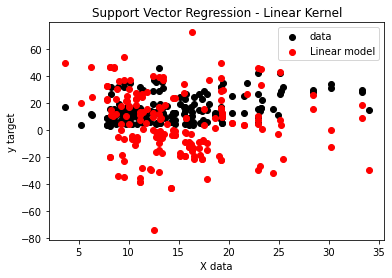

R-squared of linear kernel SVR: -6.66
MSE of linear kernel SVR : 691.11
MAE of linear kernel SVR : 21.0


In [429]:
### svr models using rbf, linear, polynomial kernels
### linear kernel
fun_svr_lin = SVR(kernel='linear', max_iter=-1, C=1e4)
y_lin = fun_svr_lin.fit(X_rio, y_rio).predict(X_rio)
pl.scatter(X_rio[['pm25_ou']], y_rio, c='k', label='data')
pl.scatter(X_rio[['pm25_ou']], y_lin, c='r', label='Linear model')
pl.xlabel('X data')
pl.ylabel('y target')
pl.title('Support Vector Regression - Linear Kernel')
pl.legend()
pl.show()

lin_r2 = round(fun_svr_lin.score(X_rio,y_rio),2)
lin_mse= round(mean_squared_error(y_rio, y_lin),2)
lin_mae= round(mean_absolute_error(y_rio, y_lin),2)
print('R-squared of linear kernel SVR:', lin_r2)
print('MSE of linear kernel SVR :', lin_mse)
print('MAE of linear kernel SVR :', lin_mae)

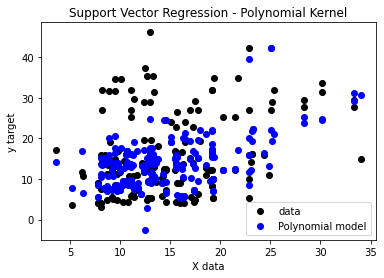

R-squared of polynomial kernel SVR: 0.36
MSE of polynomial kernel SVR: 58.12
MAE of polynomial kernel SVR: 5.04


In [430]:
### polynomial kernel
fun_svr_poly = SVR(kernel='poly', C=1e4, degree=2, max_iter=-1)
y_poly = fun_svr_poly.fit(X_rio, y_rio).predict(X_rio)
pl.scatter(X_rio[['pm25_ou']], y_rio, c='k', label='data')
pl.scatter(X_rio[['pm25_ou']], y_poly, c='b', label='Polynomial model')
pl.xlabel('X data')
pl.ylabel('y target')
pl.title('Support Vector Regression - Polynomial Kernel')
pl.legend()
pl.show()

poly_r2 = round(fun_svr_poly.score(X_rio,y_rio),2)
poly_mse= round(mean_squared_error(y_rio, y_poly),2)
poly_mae= round(mean_absolute_error(y_rio, y_poly),2)

print('R-squared of polynomial kernel SVR:', poly_r2)
print('MSE of polynomial kernel SVR:', poly_mse)
print('MAE of polynomial kernel SVR:', poly_mae)

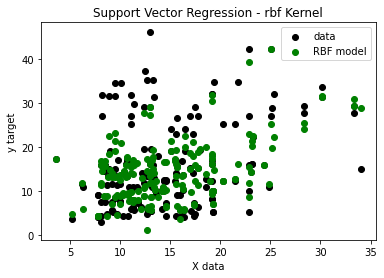

R-squared of rbf kernel SVR: 0.51
MSE of rbf kernel SVR: 44.53
MAE of rbf kernel SVR: 4.31


In [431]:
### rbf kernel 
fun_svr_rbf = SVR(kernel='rbf', C=1e4, max_iter=-1)
y_rbf = fun_svr_rbf.fit(X_rio, y_rio).predict(X_rio)
pl.scatter(X_rio[['pm25_ou']], y_rio, c='k', label='data')
pl.scatter(X_rio[['pm25_ou']], y_rbf, c='g', label='RBF model')
pl.xlabel('X data')
pl.ylabel('y target')
pl.title('Support Vector Regression - rbf Kernel')
pl.legend()
pl.show()

rbf_r2= round(fun_svr_rbf.score(X_rio,y_rio),2)
rbf_mse= round(mean_squared_error(y_rio, y_rbf),2)
rbf_mae= round(mean_absolute_error(y_rio, y_rbf),2)

print('R-squared of rbf kernel SVR:', rbf_r2)
print('MSE of rbf kernel SVR:', rbf_mse)
print('MAE of rbf kernel SVR:', rbf_mae)

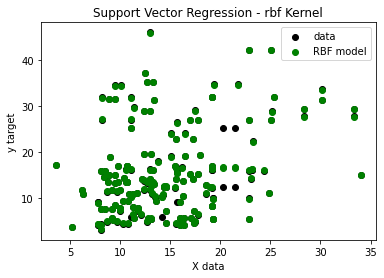

R-squared of rbf kernel SVR: 0.98
MSE of rbf kernel SVR: 1.42
MAE of rbf kernel SVR (gamma=auto): 0.31


In [432]:
### rbf kernel with gamma='auto'
fun_svr_rbf2 = SVR(kernel='rbf', C=1e4, gamma='auto', max_iter=-1)
y_rbf2 = fun_svr_rbf2.fit(X_rio, y_rio).predict(X_rio)
pl.scatter(X_rio[['pm25_ou']], y_rio, c='k', label='data')
pl.scatter(X_rio[['pm25_ou']], y_rbf2, c='g', label='RBF model')
pl.xlabel('X data')
pl.ylabel('y target')
pl.title('Support Vector Regression - rbf Kernel')
pl.legend()
pl.show()

rbf_auto_r2 = round(fun_svr_rbf2.score(X_rio,y_rio),2)
rbf_auto_mse= round(mean_squared_error(y_rio, y_rbf2),2)
rbf_auto_mae= round(mean_absolute_error(y_rio, y_rbf2),2)

print('R-squared of rbf kernel SVR:', rbf_auto_r2)
print('MSE of rbf kernel SVR:', rbf_auto_mse)
print('MAE of rbf kernel SVR (gamma=auto):', rbf_auto_mae)

In [433]:
print("R-squared of linear kernel SVR:", lin_r2)
print("R-squared of polynomial kernel SVR:", poly_r2)
print("R-squared of rbf kernel SVR:", rbf_r2)
print("R-squared of rbf kernel SVR (gamma=auto):", rbf_auto_r2)
print(' ')
print("MSE of linear kernel SVR :", lin_mse)
print("MSE of polynomial kernel SVR:", poly_mse)
print("MSE of rbf kernel SVR:", rbf_mse)
print("MSE of rbf kernel SVR (gamma=auto):", rbf_auto_mse)
print(' ')
print("MAE of linear kernel SVR :", lin_mae)
print("MAE of polynomial kernel SVR:", poly_mae)
print("MAE of rbf kernel SVR:", rbf_mae)
print("MAE of rbf kernel SVR (gamma=auto):", rbf_auto_mae)

R-squared of linear kernel SVR: -6.66
R-squared of polynomial kernel SVR: 0.36
R-squared of rbf kernel SVR: 0.51
R-squared of rbf kernel SVR (gamma=auto): 0.98
 
MSE of linear kernel SVR : 691.11
MSE of polynomial kernel SVR: 58.12
MSE of rbf kernel SVR: 44.53
MSE of rbf kernel SVR (gamma=auto): 1.42
 
MAE of linear kernel SVR : 21.0
MAE of polynomial kernel SVR: 5.04
MAE of rbf kernel SVR: 4.31
MAE of rbf kernel SVR (gamma=auto): 0.31


With a fairly high regularization (C=1e4) and a gamma that is a function of the variance of X (gamma='scale'), the rbf kernel scores best with a R-squared of 0.51, a MSE of 44.5 and a MAE of 4.3. When removing the dependency of the rbf kernel coefficient on the variance of X, rbf improves dramatically to reach a R-squared of 0.98, a MSE of 1.4 and a MAE of 0.3. I am afraid that this last model is overfitting the training data and as a consequence I will use Kfold as an iterator method in cross validation and activate shuffling of the samples.
Below I perform a cross-validation grid search to determine the best C and gamma parameters to use with the rbf kernel and this dataset. I proceed in two passes: the first pass uses a logarithmic (base 10) grid search to sweep through a large range of values; the second pass is more granular by performing the grid search around the best estimators evaluated by the first pass.

In [434]:
### create training and testing sets from X and y
X_rio_svr_train, X_rio_svr_test, y_rio_svr_train, y_rio_svr_test = train_test_split(X_rio, y_rio, test_size = 0.3, shuffle=True, random_state= 13)

### scale X_train, X_test
svr_scaler=RobustScaler()
X_rio_svr_train_scaled=svr_scaler.fit_transform(X_rio_svr_train)
X_rio_svr_test_scaled=svr_scaler.transform(X_rio_svr_test)

In [435]:
print(X_rio_svr_train.shape, X_rio_svr_test.shape, y_rio_svr_train.shape, y_rio_svr_test.shape)

(130, 20) (56, 20) (130, 1) (56, 1)


In [436]:
### gridsearch!
## set the parameter grid for a first pass
## which uses a logarithmic grid of base 10
c_range=10.**np.arange(-3,8)
gamma_range=10.**np.arange(-5,4)

parameters={'gamma': gamma_range, 
                 'C': c_range}
k_fold = KFold(n_splits=5, shuffle=True, random_state=13)

scoring_svr={'neg_mean_absolute_error':'neg_mean_absolute_error', 'r2':'r2'}

## fill GridSearchCV and fit
grid1= GridSearchCV(estimator=SVR(), param_grid= parameters, scoring=scoring_svr, refit='r2', cv=k_fold)
grid1.fit(X_rio_svr_train_scaled, y_rio_svr_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'r2': 'r2'})

The best estimators for C and gamma are: SVR(C=1000.0, gamma=1.0)


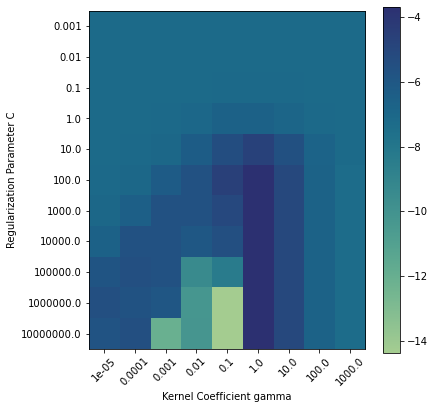

In [437]:
##### visualize the results of the first pass

## store the cross validation results in a dataframe
svr_cv_res=grid1.cv_results_
svr_cv_res_df=pd.DataFrame(svr_cv_res)

## comment on the best estimator
print('The best estimators for C and gamma are:', grid1.best_estimator_)

## heatmap to find best gamma and c
grid1_scores_= np.array(svr_cv_res_df.mean_test_neg_mean_absolute_error).reshape(len(c_range), len(gamma_range))
pl.figure(figsize=(6,6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(grid1_scores_, interpolation='nearest', cmap='crest')
pl.xlabel('Kernel Coefficient gamma')
pl.ylabel('Regularization Parameter C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(c_range)), c_range)
pl.show()

In [438]:
### gridsearch!
## set the parameter grid for a second pass
## which tries out values around the best estimators
## values provided by the first pass
c_range=np.arange(200,5000,100)
gamma_range=np.arange(0.1,8,0.1)

parameters={'gamma': gamma_range, 
                 'C': c_range}

k_fold = KFold(n_splits=5, shuffle=True, random_state=13)

scoring_svr={'neg_mean_absolute_error':'neg_mean_absolute_error', 'r2':'r2'}

## fill GridSearchCV and fit
grid2= GridSearchCV(estimator=SVR(), param_grid= parameters, scoring=scoring_svr, refit='r2', cv=k_fold)
grid2.fit(X_rio_svr_train_scaled, y_rio_svr_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
       2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400,
       3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500,
       4600, 4700, 4800, 4900]),
                         'gamma': array(...2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9])},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      

The best estimators for C and gamma are: SVR(C=3800, gamma=1.1)


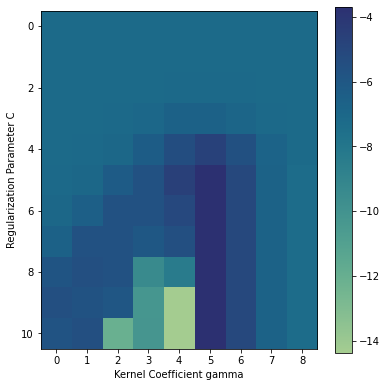

In [439]:
##### visualize the results of the second pass

## store the cross validation results in a dataframe
svr_cv_res2=grid2.cv_results_
svr_cv_res2_df=pd.DataFrame(svr_cv_res2)

## comment on the best estimator
print('The best estimators for C and gamma are:', grid2.best_estimator_)

## heatmap to find best gamma and c
grid2_scores_= np.array(svr_cv_res2_df.mean_test_neg_mean_absolute_error).reshape(len(c_range), len(gamma_range))
pl.figure(figsize=(6,6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(grid1_scores_, interpolation='nearest', cmap='crest')
pl.xlabel('Kernel Coefficient gamma')
pl.ylabel('Regularization Parameter C')
pl.colorbar()
pl.show()

In [440]:
### rbf kernel with optimize gamma and C (1st pass)
svr_rbf_opt1 = SVR(kernel='rbf', C=1000, gamma=1.0)
y_rbf_opt1 = svr_rbf_opt1.fit(X_rio_svr_train_scaled,y_rio_svr_train).predict(X_rio_svr_train_scaled)
rbf1_train_r2 = round(svr_rbf_opt1.score(X_rio_svr_train_scaled,y_rio_svr_train),2)
rbf1_train_mse= round(mean_squared_error(y_rio_svr_train, y_rbf_opt1),2)
rbf1_train_mae= round(mean_absolute_error(y_rio_svr_train, y_rbf_opt1),2)

print("R-squared of rbf kernel SVR (train):", rbf1_train_r2)
print("MSE of rbf kernel SVR (train):", rbf1_train_mse)
print("MAE of rbf kernel SVR (train):", rbf1_train_mae)

R-squared of rbf kernel SVR (train): 0.98
MSE of rbf kernel SVR (train): 1.68
MAE of rbf kernel SVR (train): 0.33


In [441]:
### predicting test values using the optimized model (1st pass)
y_rbf_opt_test1 = svr_rbf_opt1.predict(X_rio_svr_test_scaled)
rbf1_test_r2= round(svr_rbf_opt1.score(X_rio_svr_test_scaled,y_rio_svr_test),2)
rbf1_test_mse= round(mean_squared_error(y_rio_svr_test, y_rbf_opt_test1) ,2)
rbf1_test_mae= round( mean_absolute_error(y_rio_svr_test, y_rbf_opt_test1),2)

print("R-squared of rbf kernel SVR (test):", rbf1_test_r2)
print("MSE of rbf kernel SVR (test):", rbf1_test_mse)
print("MAE of rbf kernel SVR (test):", rbf1_test_mae)

R-squared of rbf kernel SVR (test): 0.37
MSE of rbf kernel SVR (test): 60.91
MAE of rbf kernel SVR (test): 4.79


In [442]:
### rbf kernel with optimize gamma and C (lower gamma)
svr_rbf_opt2 = SVR(kernel='rbf', C=3800, gamma=1.1)
y_rbf_opt2 = svr_rbf_opt2.fit(X_rio_svr_train_scaled,y_rio_svr_train).predict(X_rio_svr_train_scaled)
rbf2_train_r2 = round(svr_rbf_opt2.score(X_rio_svr_train_scaled,y_rio_svr_train),2)
rbf2_train_mse= round(mean_squared_error(y_rio_svr_train, y_rbf_opt2),2)
rbf2_train_mae= round(mean_absolute_error(y_rio_svr_train, y_rbf_opt2),2)

print("R-squared of rbf kernel SVR:", rbf2_train_r2)
print("MSE of rbf kernel SVR:", rbf2_train_mse )
print("MAE of rbf kernel SVR:", rbf2_train_mae)

R-squared of rbf kernel SVR: 0.99
MSE of rbf kernel SVR: 0.66
MAE of rbf kernel SVR: 0.23


In [443]:
### predicting test values using the optimized model (2nd pass)
y_rbf_opt_test2 = svr_rbf_opt2.predict(X_rio_svr_test_scaled)
rbf2_test_r2 = round(svr_rbf_opt2.score(X_rio_svr_test_scaled,y_rio_svr_test),2)
rbf2_test_mse= round(mean_squared_error(y_rio_svr_test, y_rbf_opt_test2),2)
rbf2_test_mae= round(mean_absolute_error(y_rio_svr_test, y_rbf_opt_test2),2)

print("R-squared of rbf kernel SVR:", rbf2_test_r2)
print("MSE of rbf kernel SVR:", rbf2_test_mse)
print("MAE of rbf kernel SVR:", rbf2_test_mae)

R-squared of rbf kernel SVR: 0.38
MSE of rbf kernel SVR: 60.77
MAE of rbf kernel SVR: 4.84


The first pass grid search cross validation estimates the optimum C and gamma to be 1000 and 0.7, respectively, and deliver on the train set a R-squared of 0.98, a MSE of 1.7, and a MAE of 0.3. The second pass grid search cross validation estimates the optimum C and gamma to be 3800 and 1.1, respectively, and deliver on the train set a R-squared of 0.99, a MSE of 0.65, and a MAE of 0.2. Unfortunately in both cases the scores on the test set is much lower with a R-squared of 0.4, a MSE of 61, and a MAE of 4.8. The model is definitely overfitting the train set and not performing well on the test set despite using shuffling, KFold, and refitting the grid search from MAE to R-squared. 

When considering the MAE in the 'real world of pollutant emission and measurements,  4.8 ug/m3 is not far from the mean absolute error in PM 2.5 measurements which may be as high as 6 ug/m3 at the sensor's head.[https://www.researchgate.net/figure/Mean-absolute-error-in-PM25-measurements-for-two-NPM-sensors-during-long-term-459_fig2_332231714]

I think SVR is good enough for further consideration because the MAE fits into the reality of the data. I could reduce the influence radius of each training sample (i.e. increase gamma) to reduce overfitting but this would increase the MAE. The cross-validation scores are satisfactory.

In [444]:
### cross validation scores
svr_rbf_opt2_cv_scores_train_mae= cross_val_score(svr_rbf_opt2,X_rio_svr_train_scaled,y_rio_svr_train,cv=5,scoring='neg_mean_absolute_error')
svr_rbf_opt2_cv_scores_test_mae= cross_val_score(svr_rbf_opt2,X_rio_svr_test_scaled,y_rio_svr_test,cv=5,scoring='neg_mean_absolute_error')

svr_rbf_opt2_cv_scores_train_r2= cross_val_score(svr_rbf_opt2,X_rio_svr_train_scaled,y_rio_svr_train,cv=5,scoring='r2')
svr_rbf_opt2_cv_scores_test_r2= cross_val_score(svr_rbf_opt2,X_rio_svr_test_scaled,y_rio_svr_test,cv=5,scoring='r2')


svr_rbf_opt2_cv_scores_mean_train_mae= round(svr_rbf_opt2_cv_scores_train_mae.mean(),2)
svr_rbf_opt2_cv_scores_std_train_mae= round(svr_rbf_opt2_cv_scores_train_mae.std(),2)
svr_rbf_opt2_cv_scores_mean_test_mae= round(svr_rbf_opt2_cv_scores_test_mae.mean(),2)
svr_rbf_opt2_cv_scores_std_test_mae= round(svr_rbf_opt2_cv_scores_test_mae.std(),2)

svr_rbf_opt2_cv_scores_mean_train_r2= round(svr_rbf_opt2_cv_scores_train_r2.mean(),2)
svr_rbf_opt2_cv_scores_std_train_r2= round(svr_rbf_opt2_cv_scores_train_r2.std(),2)
svr_rbf_opt2_cv_scores_mean_test_r2= round(svr_rbf_opt2_cv_scores_test_r2.mean(),2)
svr_rbf_opt2_cv_scores_std_test_r2= round(svr_rbf_opt2_cv_scores_test_r2.std(),2)


print('Cross validation scores:')
print ('mean MAE of SVR (train set) is: ', svr_rbf_opt2_cv_scores_mean_train_mae, '+/-', svr_rbf_opt2_cv_scores_std_train_mae)
print ('mean MAE of SVR (test set) is: ', svr_rbf_opt2_cv_scores_mean_test_mae, '+/-', svr_rbf_opt2_cv_scores_std_test_mae)
print ('R2 of SVR (train set) is: ', svr_rbf_opt2_cv_scores_mean_train_r2, '+/-', svr_rbf_opt2_cv_scores_std_train_r2)
print ('R2 of SVR (test set) is: ', svr_rbf_opt2_cv_scores_mean_test_r2, '+/-', svr_rbf_opt2_cv_scores_std_test_r2)

Cross validation scores:
mean MAE of SVR (train set) is:  -4.22 +/- 0.5
mean MAE of SVR (test set) is:  -6.64 +/- 1.29
R2 of SVR (train set) is:  0.54 +/- 0.07
R2 of SVR (test set) is:  0.18 +/- 0.14


In [445]:
### save records
svr_rows=pd.DataFrame(data={'Model Type': ['SVR (train)', 'SVR (test)', 'SVR (cv train)', 'SVR (cv test)'], 'R2':[rbf2_train_r2, rbf2_test_r2,svr_rbf_opt2_cv_scores_mean_train_r2, svr_rbf_opt2_cv_scores_mean_test_r2],
                            'MAE':[rbf2_train_mae, rbf2_test_mae,svr_rbf_opt2_cv_scores_mean_train_mae,svr_rbf_opt2_cv_scores_mean_test_mae],
                            'Accuracy(cv)':['NA','NA','NA','NA'],
                            'Accuracy':['NA','NA', 'NA','NA'],'Recall':['NA','NA', 'NA','NA'],'Precision':['NA','NA', 'NA','NA'],
                            'Nota Bene':['Model overfits train set','Model overfits train set','low performance','low performance']}, index=[0,1,2,3])
records=records.append(svr_rows)

<a class="anchor" id="section4_1_4"></a>
### 4.1.4. Logistic Regression.
Logistic regression is a classification method which measures the relationship between the dependent variable (y) and the predictors (X) by estimating the probability of occurrence of an event using its logistics function. y is treated as a categorical variable and therefore the AQI categories of the indoor PM 2.5 will be used instead of the measured concentrations. By contrast with SVR, logistic regression offers many hyperparameters to tune the model. For the purpose of this project, only the parameters C, which is the same C as in SVR, is important. The penalty is 'l2' by default.

In [446]:
### Shape up the dataframe
cat_riopa=feat_riopa_aqi.drop(columns=['pm25_in','pm25_ou','pm25_pt_in','pm25_pt_ou'], inplace=False)
cat_riopa=cat_riopa.astype({'dust_sand':'uint8','smoke_haze':'uint8','thunder':'uint8',
                              'fog_all':'uint8','snow_all':'uint8','rain_all':'uint8',
                              'wind_dmg':'uint8','wind_all':'uint8','landuse_main_Residential':'uint8',
                              'landuse_near_Park':'uint8','landuse_near_Residential':'uint8',
                               'aqi_pm25_ou':'category','aqi_pm25_in':'category',})
cat_riopa=pd.get_dummies(cat_riopa, columns=['aqi_pm25_ou'])
cat_riopa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 404
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ambient_temp_c_in         186 non-null    float64 
 1   airexrate_in              186 non-null    float64 
 2   ambient_rh_in             186 non-null    float64 
 3   rh_ou                     186 non-null    float64 
 4   dust_sand                 186 non-null    uint8   
 5   rain_prcp                 186 non-null    float64 
 6   smoke_haze                186 non-null    uint8   
 7   temp_max                  186 non-null    float64 
 8   thunder                   186 non-null    uint8   
 9   wind_avgspeed             186 non-null    float64 
 10  wind_fastest_2min         186 non-null    float64 
 11  fog_all                   186 non-null    uint8   
 12  snow_all                  186 non-null    uint8   
 13  rain_all                  186 non-null    uint8   

In [447]:
### X and y for Logistic Regression
X_rio_log=cat_riopa.drop(columns='aqi_pm25_in', inplace=False)
y_rio_log= cat_riopa[['aqi_pm25_in']]

### create stratified training and testing sets from X and y
skf_log = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_log.get_n_splits(X_rio_log, y_rio_log)

for train_index, test_index in skf_log.split(X_rio_log, y_rio_log):
    X_rio_log_train, X_rio_log_test = X_rio_log.iloc[train_index], X_rio_log.iloc[test_index]
    y_rio_log_train, y_rio_log_test = y_rio_log.iloc[train_index], y_rio_log.iloc[test_index]

### scale X_train, X_test
log_scaler=RobustScaler()
X_rio_log_train_scaled=log_scaler.fit_transform(X_rio_log_train)
X_rio_log_test_scaled=log_scaler.transform(X_rio_log_test)

print(X_rio_log.shape, y_rio_log.shape)
print(X_rio_log_train.shape, X_rio_log_test.shape, y_rio_log_train.shape, y_rio_log_test.shape)
print(X_rio_log_train_scaled.shape, X_rio_log_test_scaled.shape )

(186, 21) (186, 1)
(140, 21) (46, 21) (140, 1) (46, 1)
(140, 21) (46, 21)


In [448]:
print(skf_log)

StratifiedKFold(n_splits=4, random_state=13, shuffle=True)


In [449]:
##### cross validation with gridsearch
## set the parameter 
c_range=10.**np.arange(-3,8)
sk_fold_log = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters_log={'C': c_range, 'solver': ['lbfgs','newton-cg']}

scoring_log={'accuracy':'accuracy'}

## fill GridSearchCV and fit
grid_log1= GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'), param_grid= parameters_log, scoring=scoring_log, refit='accuracy', cv=sk_fold_log)
grid_log1.fit(X_rio_log_train_scaled, y_rio_log_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'solver': ['lbfgs', 'newton-cg']},
             refit='accuracy', scoring={'accuracy': 'accuracy'})

In [450]:
##### visualize the results 

## store the cross validation results in a dataframe
log_cv_res1=grid_log1.cv_results_
log_cv_res1_df=pd.DataFrame(log_cv_res1)

log_train_r2=round(log_cv_res1_df.mean_test_accuracy.max(),2)

print('The accuracy of the Multi-class Logistic Regression is:', log_train_r2 )
print('The best estimators for the Multi-class Logistic Regression are:',log_cv_res1_df.loc[log_cv_res1_df.rank_test_accuracy==1])

The accuracy of the Multi-class Logistic Regression is: 0.75
The best estimators for the Multi-class Logistic Regression are:    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
6       0.014792      0.002134         0.000200        0.000400       1   
7       0.015391      0.003320         0.000200        0.000400       1   
8       0.023187      0.000748         0.000600        0.000490      10   
9       0.017791      0.003598         0.000399        0.000489      10   

  param_solver                              params  split0_test_accuracy  \
6        lbfgs       {'C': 1.0, 'solver': 'lbfgs'}              0.785714   
7    newton-cg   {'C': 1.0, 'solver': 'newton-cg'}              0.785714   
8        lbfgs      {'C': 10.0, 'solver': 'lbfgs'}              0.785714   
9    newton-cg  {'C': 10.0, 'solver': 'newton-cg'}              0.785714   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
6                  0.75              0.714286 

The grid search indicates that the best C is 1 or 10 and the type of solver does not matter for an accuracy score of 0.76.
I am going to apply C=1.0 and solver='lbfgs' (which implies penalty='l2' because others are not supported) on the training set, test it and print the confusion matrix.

In [451]:
### Test the best parameters
logreg1=LogisticRegression(solver='lbfgs', C=1.0, multi_class='multinomial', penalty='l2', random_state=13 )
logreg1.fit(X_rio_log_train_scaled, y_rio_log_train)
y_pred_logreg=logreg1.predict(X_rio_log_test_scaled)
logreg1_score=logreg1.score(X_rio_log_test_scaled,y_rio_log_test)

log_test_r2= round(logreg1_score,2)

print('The prediction accuracy of the Multiclass Logistic regression model is:', log_test_r2)

The prediction accuracy of the Multiclass Logistic regression model is: 0.76


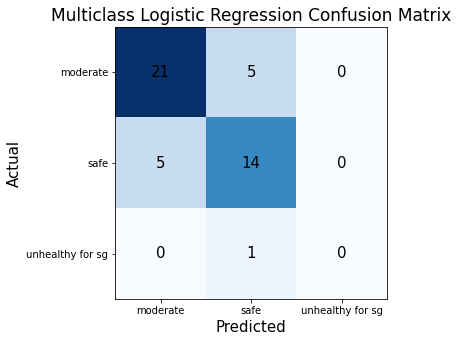

In [452]:
### confusion matrix
cm_log=confusion_matrix(y_rio_log_test,y_pred_logreg)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Multiclass Logistic Regression Confusion Matrix', fontsize=17)
ax.imshow(cm_log,cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted', fontsize=15, color='black')
ax.set_ylabel('Actual', fontsize=15, color='black')
ax.xaxis.set(ticks=range(3))
ax.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
ax.yaxis.set(ticks=range(3))
ax.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
ax.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_log[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

The Multiclass Logistic Regression provides good results with an accuracy of 0.75 on the training set which translated into an accuracy of 0.76 on the test set.
The confusion matrix shows:
-14 correct predictions of 'safe' (14/19)
-21 correct predictions of 'moderate' (21/26)
-cannot predict 'unhealthy for sensitive group' (0/1)
-1 'unhealthy for sensitive group' misclassified  as 'moderate'
-5 'moderate' misclassified  as 'safe'
-4 'safe' misclassified  as 'moderate' 
-1 'safe' misclassified  as 'unhealthy for sensitive group' 

I am not happy that the model does not pick up at all on the class 'unhealthy' which exists, thanks to Stratified KFold, in both train and test set (as show below) but the amount of 'unhealthy' is limited to 4 rows in the whole dataset. Even if I use class_weight='balanced', the outlier class does not get identified and te overall performance of the model decreases. Cross validation scores are 0.7+/-0.1 and 0.5+/-0.1 for the training set and testing set, respectively. I am going to rework the model using the smote method.

In [453]:
y_rio_log_train.aqi_pm25_in.value_counts()

moderate                          78
safe                              59
unhealthy for sensitive groups     3
Name: aqi_pm25_in, dtype: int64

In [454]:
y_rio_log_test.aqi_pm25_in.value_counts()

moderate                          26
safe                              19
unhealthy for sensitive groups     1
Name: aqi_pm25_in, dtype: int64

In [455]:
### cross validation scores
logreg1_cv_scores_train= cross_val_score(logreg1,X_rio_log_train_scaled,y_rio_log_train,cv=5,scoring='accuracy')
logreg1_cv_scores_test= cross_val_score(logreg1,X_rio_log_test_scaled,y_rio_log_test,cv=5,scoring='accuracy')

logreg1_cv_scores_mean_train= logreg1_cv_scores_train.mean()
logreg1_cv_scores_std_train= logreg1_cv_scores_train.std()
logreg1_cv_scores_mean_test= logreg1_cv_scores_test.mean()
logreg1_cv_scores_std_test= logreg1_cv_scores_test.std()

print('Cross validation scores:')
print ('mean accuracy of multiclass logistic regression (train set) is: ', round(logreg1_cv_scores_mean_train,1), '+/-',round(logreg1_cv_scores_std_train,1))
print ('mean accuracy of multiclass logistic regression (test set) is: ', round(logreg1_cv_scores_mean_test,1), '+/-',round(logreg1_cv_scores_std_test,1))

Cross validation scores:
mean accuracy of multiclass logistic regression (train set) is:  0.7 +/- 0.1
mean accuracy of multiclass logistic regression (test set) is:  0.5 +/- 0.1


Precision and recall scores are also valuable metrics to evaluate classification problems. I use the function get_components to extract the true positive, true negative,false negative and false positive from the confusion matrix and then perform metrics calculation with matrix_scores. If I want an overall evaluation I pass the output of get_components into sum_components prior to running matrix_scores.

In [456]:
### To extract numbers from the confusion matrix
def get_components(conf_matrix):
    '''extract the four components of the matrix'''
    fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    tp = np.diag(conf_matrix)
    tn = conf_matrix.sum() - (fp + fn + tp)
    fp = fp.astype(float)
    fn = fn.astype(float)
    tp = tp.astype(float)
    tn = tn.astype(float)
    return tp, tn, fp, fn

def sum_components(tp, tn, fp, fn):
    '''sum components for overall evaluation'''
    stp, stn, sfp, sfn= 0,0,0,0
    for i in range(0,3):
        stp=stp+tp[i]
        stn=stn+tn[i]
        sfp=sfp+fp[i]
        sfn=sfn+fn[i]
    return stp, stn, sfp, sfn

def matrix_scores (tp, tn, fp, fn):
    '''calculate matrix_scores from sum_components and get_components'''
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    return recall, precision, accuracy

In [457]:
tp, tn, fp, fn = get_components(cm_log)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
logreg1_cv_recall, logreg1_cv_precision, logreg1_cv_accuracy=matrix_scores(tp, tn, fp, fn)
print('Cross validation scores:')
print ('mean accuracy of multiclass logistic regression (cv) is: ', round(logreg1_cv_accuracy,2))
print ('recall is ',round(logreg1_cv_recall,2), 'and precision is', round(logreg1_cv_precision,2))

Cross validation scores:
mean accuracy of multiclass logistic regression (cv) is:  0.84
recall is  0.76 and precision is 0.76


In [458]:
### balance classes with Smote()
smo_logreg = SMOTE(k_neighbors =3, random_state=13)
X_sm_logreg, y_sm_logreg = smo_logreg.fit_resample(X_rio_log,y_rio_log)

### create stratified training and testing sets from X and y
skf_smlog = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_smlog.get_n_splits(X_sm_logreg, y_sm_logreg)

for train_index, test_index in skf_smlog.split(X_sm_logreg, y_sm_logreg):
    X_sm_logreg_train, X_sm_logreg_test = X_sm_logreg.iloc[train_index], X_sm_logreg.iloc[test_index]
    y_sm_logreg_train, y_sm_logreg_test = y_sm_logreg.iloc[train_index], y_sm_logreg.iloc[test_index]

### scale X_train, X_test
sm_log_scaler=RobustScaler()
X_sm_logreg_train_scaled=log_scaler.fit_transform(X_sm_logreg_train)
X_sm_logreg_test_scaled=log_scaler.transform(X_sm_logreg_test)

print(X_sm_logreg.shape, y_sm_logreg.shape)
print(X_sm_logreg_train.shape, X_sm_logreg_test.shape, y_sm_logreg_train.shape, y_sm_logreg_test.shape)
print(X_sm_logreg_train_scaled.shape, X_sm_logreg_test_scaled.shape )

(312, 21) (312, 1)
(234, 21) (78, 21) (234, 1) (78, 1)
(234, 21) (78, 21)


In [459]:
### compute_class_weight pre-smote and post-smote and save in a dictionary
logreg_weights = compute_class_weight('balanced', np.unique(y_rio_log), y = np.ravel(y_rio_log))

logreg_w={}
for k, v in zip(np.unique(y_rio_log), logreg_weights):
    logreg_w[k] = v
    
sm_logreg_weights = compute_class_weight('balanced', np.unique(y_sm_logreg), y = np.ravel(y_sm_logreg))

sm_logreg_w={}
for k, v in zip(np.unique(y_sm_logreg), sm_logreg_weights):
    sm_logreg_w[k] = v    

print('ideal weights to apply to classes:')
print('pre-smote:', logreg_w)
print('post-smote:', sm_logreg_w)

ideal weights to apply to classes:
pre-smote: {'moderate': 0.5961538461538461, 'safe': 0.7948717948717948, 'unhealthy for sensitive groups': 15.5}
post-smote: {'moderate': 1.0, 'safe': 1.0, 'unhealthy for sensitive groups': 1.0}


In [460]:
##### cross validation with gridsearch
## set the parameter 
c_range=10.**np.arange(-3,8)
sk_fold_logsm = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters_log={'C': c_range, 'solver': ['lbfgs','newton-cg']}

scoring_log={'accuracy':'accuracy'}

## fill GridSearchCV and fit
grid_logsm= GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'), param_grid= parameters_log, scoring=scoring_log, refit='accuracy', cv=sk_fold_logsm)
grid_logsm.fit(X_sm_logreg_train_scaled, y_sm_logreg_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'solver': ['lbfgs', 'newton-cg']},
             refit='accuracy', scoring={'accuracy': 'accuracy'})

In [461]:
## store the cross validation results in a dataframe
logsm_cv_res1=grid_logsm.cv_results_
logsm_cv_res1_df=pd.DataFrame(logsm_cv_res1)
print('The accuracy of the Multi-class Logistic Regression is:', round(logsm_cv_res1_df.mean_test_accuracy.max(),2))
print('The best estimators for the Multi-class Logistic Regression are:',logsm_cv_res1_df.loc[logsm_cv_res1_df.rank_test_accuracy==1])

The accuracy of the Multi-class Logistic Regression is: 0.88
The best estimators for the Multi-class Logistic Regression are:    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
9       0.023385      0.000487         0.000802        0.000401      10   

  param_solver                              params  split0_test_accuracy  \
9    newton-cg  {'C': 10.0, 'solver': 'newton-cg'}              0.914894   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
9              0.829787              0.829787               0.93617   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
9              0.869565            0.876041           0.043464   

   rank_test_accuracy  
9                   1  


In [462]:
### Test the best parameters
logregsm=LogisticRegression(solver='newton-cg', C=10.0, multi_class='multinomial', penalty='l2', random_state=13 )
logregsm.fit(X_sm_logreg_train_scaled, y_sm_logreg_train)
y_pred_logregsm=logregsm.predict(X_sm_logreg_test_scaled)
logregsm_score=logregsm.score(X_sm_logreg_test_scaled,y_sm_logreg_test)
print('The prediction accuracy of the Multiclass Logistic regression model is:', round(logregsm_score,2))

The prediction accuracy of the Multiclass Logistic regression model is: 0.85


In [463]:
### cross validation scores
logregsm_cv_scores_train= cross_val_score(logregsm,X_sm_logreg_train_scaled,y_sm_logreg_train,cv=5,scoring='accuracy')
logregsm_cv_scores_test= cross_val_score(logregsm,X_sm_logreg_test_scaled,y_sm_logreg_test,cv=5,scoring='accuracy')

logregsm_cv_scores_mean_train= logregsm_cv_scores_train.mean()
logregsm_cv_scores_std_train= logregsm_cv_scores_train.std()
logregsm_cv_scores_mean_test= logregsm_cv_scores_test.mean()
logregsm_cv_scores_std_test= logregsm_cv_scores_test.std()

print('Cross validation scores:')
print ('mean accuracy of multiclass logistic regression (train set) is: ', round(logregsm_cv_scores_mean_train,1), '+/-',round(logregsm_cv_scores_std_train,1))
print ('mean accuracy of multiclass logistic regression (test set) is: ', round(logregsm_cv_scores_mean_test,1), '+/-',round(logregsm_cv_scores_std_test,1))

Cross validation scores:
mean accuracy of multiclass logistic regression (train set) is:  0.8 +/- 0.1
mean accuracy of multiclass logistic regression (test set) is:  0.7 +/- 0.1


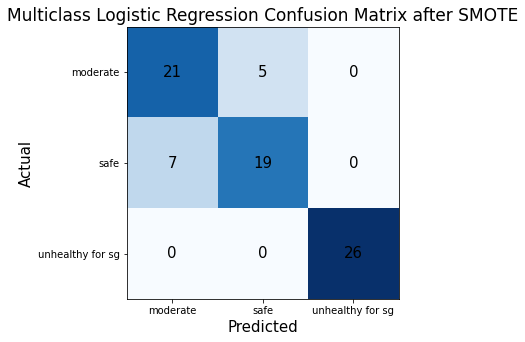

In [464]:
### confusion matrix
cm_logsm=confusion_matrix(y_sm_logreg_test,y_pred_logregsm)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Multiclass Logistic Regression Confusion Matrix after SMOTE', fontsize=17)
ax.imshow(cm_logsm,cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted', fontsize=15, color='black')
ax.set_ylabel('Actual', fontsize=15, color='black')
ax.xaxis.set(ticks=range(3))
ax.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
ax.yaxis.set(ticks=range(3))
ax.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
ax.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_logsm[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [465]:
tp, tn, fp, fn = get_components(cm_logsm)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
logregsm_cv_recall, logregsm_cv_precision, logregsm_cv_accuracy=matrix_scores(tp, tn, fp, fn)
print('Cross validation scores:')
print ('mean accuracy of multiclass logistic regression (cv) is: ', round(logregsm_cv_accuracy,2))
print ('recall is ',round(logregsm_cv_recall,2), 'and precision is', round(logregsm_cv_precision,2))

Cross validation scores:
mean accuracy of multiclass logistic regression (cv) is:  0.9
recall is  0.85 and precision is 0.85


To conclude with the Logistic Regression, the imbalance of classes seems to be the main issue when it comes to improving prediction accuracy. Rebalancing classes with the SMOTE method improved accuracy on both train set and test set and allowed the model to ''perfectly' identify the class 'unhealthy for sensitive group'.

In [466]:
### save records
logreg_rows=pd.DataFrame(data={'Model Type': ['Logistic Regression (train)','Logistic Regression (test)', 'Logistic Regression (post-smote train)', 'Logistic Regression (post-smote test)'], 
                               'R2':['NA','NA','NA','NA'], 
                               'MAE':['NA','NA','NA','NA'], 
                               'Accuracy(cv)':[logreg1_cv_scores_mean_train,logreg1_cv_scores_mean_test, logregsm_cv_scores_mean_train,logregsm_cv_scores_mean_test],
                               'Accuracy':['NA',round(logreg1_cv_accuracy,2),'NA',round(logregsm_cv_accuracy,2)],'Recall':['NA',round(logreg1_cv_recall,2),'NA',round(logregsm_cv_recall,2)],'Precision':['NA',round(logreg1_cv_precision,2),'NA',round(logregsm_cv_precision,2)],
                               'Nota Bene':['cannot identify minority class','cannot identify minority class','minority class overfitted','minority class overfitted']}, index=[0,1,2,3])
records=records.append(logreg_rows)

In [467]:
records

,Model Type,R2,MAE,Accuracy(cv),Accuracy,Recall,Precision,Nota Bene
0,Linear Regression,0.02,NA,NA,NA,NA,NA,Does not fit
1,Linear Regression OLS,0.02,NA,NA,NA,NA,NA,Does not fit
0,Multi-linear Regression (formula OLS),0.19,NA,NA,NA,NA,NA,Does not fit
2,Multi-linear Regression (formula OLS),0.24,NA,NA,NA,NA,NA,Does not fit
0,SVR (train),0.99,0.23,NA,NA,NA,NA,Model overfits train set
1,SVR (test),0.38,4.84,NA,NA,NA,NA,Model overfits train set
2,SVR (cv train),0.54,-4.22,NA,NA,NA,NA,low performance
3,SVR (cv test),0.18,-6.64,NA,NA,NA,NA,low performance
0,Logistic Regression (train),NA,NA,0.692857,NA,NA,NA,cannot identify minority class
1,Logistic Regression (test),NA,NA,0.524444,0.84,0.76,0.76,cannot identify minority class


<a class="anchor" id="section4_1_5"></a>
### 4.1.5. K Nearest Neighbors
Scikit-learn KNeighborsClassifier is a classifier which implements the k-nearest neighbors vote. As I know there is a class imbalance in the dataset, I may transform the dataset using the SMOTE method.

In [468]:
### X and y for KNN
X_rio_knn=cat_riopa.drop(columns='aqi_pm25_in', inplace=False)
y_rio_knn= cat_riopa[['aqi_pm25_in']]

### create stratified training and testing sets from X and y
skf_knn = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_knn.get_n_splits(X_rio_knn, y_rio_knn)

for train_index, test_index in skf_knn.split(X_rio_knn, y_rio_knn):
    X_rio_knn_train, X_rio_knn_test = X_rio_knn.iloc[train_index], X_rio_knn.iloc[test_index]
    y_rio_knn_train, y_rio_knn_test = y_rio_knn.iloc[train_index], y_rio_knn.iloc[test_index]

### scale X_train, X_test
knn_scaler=RobustScaler()
X_rio_knn_train_scaled=knn_scaler.fit_transform(X_rio_knn_train)
X_rio_knn_test_scaled=knn_scaler.transform(X_rio_knn_test) 

### modeling
knn_model=KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto')
knn_model.fit(X_rio_knn_train_scaled,y_rio_knn_train)
y_pred_knn = knn_model.predict(X_rio_knn_test_scaled)
print('the accuracy score of KNN is:', round(accuracy_score(y_rio_knn_test, y_pred_knn),2))

the accuracy score of KNN is: 0.85


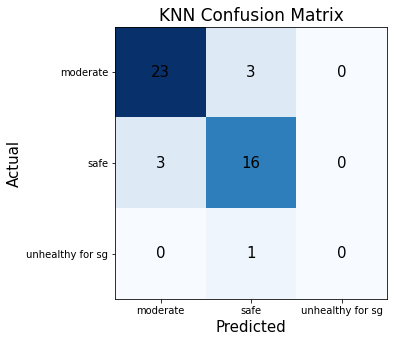

In [469]:
### confusion matrix
cm_knn=confusion_matrix(y_rio_knn_test, y_pred_knn)

fig, axk = plt.subplots(figsize=(5, 5))
axk.set_title('KNN Confusion Matrix', fontsize=17)
axk.imshow(cm_knn,cmap='Blues')
axk.grid(False)
axk.set_xlabel('Predicted', fontsize=15, color='black')
axk.set_ylabel('Actual', fontsize=15, color='black')
axk.xaxis.set(ticks=range(3))
axk.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
axk.yaxis.set(ticks=range(3))
axk.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
axk.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        axk.text(j, i, cm_knn[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [470]:
### cross validation scores
cm_knn_cv_scores_train= cross_val_score(knn_model,X_rio_knn_train_scaled,y_rio_knn_train,cv=5,scoring='accuracy')
cm_knn_cv_scores_test= cross_val_score(knn_model,X_rio_knn_test_scaled,y_rio_knn_test,cv=5,scoring='accuracy')

cm_knn_cv_scores_mean_train= cm_knn_cv_scores_train.mean()
cm_knn_cv_scores_std_train= cm_knn_cv_scores_train.std()
cm_knn_cv_scores_mean_test= cm_knn_cv_scores_test.mean()
cm_knn_cv_scores_std_test= cm_knn_cv_scores_test.std()

tp, tn, fp, fn = get_components(cm_knn)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
knn_cv_recall, knn_cv_precision, knn_cv_accuracy=matrix_scores(tp, tn, fp, fn)

print('cross validation results')
print(cm_knn_cv_scores_train)
print(cm_knn_cv_scores_test)
print('Cross validation scores:')
print ('mean accuracy of KNN (pre-smote train set) is: ', round(cm_knn_cv_scores_mean_train,1), '+/-',round(cm_knn_cv_scores_std_train,1))
print ('mean accuracy of KNN (pre-smote test set) is: ', round(cm_knn_cv_scores_mean_test,1), '+/-',round(cm_knn_cv_scores_std_test,1))
print ('overall accuracy of KNN (post-smote train set): ', round(knn_cv_accuracy,2))
print ('recall is ',round(knn_cv_recall,2), 'and precision is', round(knn_cv_precision,2))

cross validation results
[0.39285714 0.75       0.64285714 0.78571429 0.53571429]
[0.4        0.44444444 0.55555556 0.         0.22222222]
Cross validation scores:
mean accuracy of KNN (pre-smote train set) is:  0.6 +/- 0.1
mean accuracy of KNN (pre-smote test set) is:  0.3 +/- 0.2
overall accuracy of KNN (post-smote train set):  0.9
recall is  0.85 and precision is 0.85


In [471]:
#### SMOTE

### balance classes with Smote()
smo_knn = SMOTE(k_neighbors =3, random_state=13)
X_sm_knn, y_sm_knn = smo_knn.fit_resample(X_rio_knn,y_rio_knn)

### create stratified training and testing sets from X and y
sm_skf_knn = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
sm_skf_knn.get_n_splits(X_sm_knn, y_sm_knn)

for train_index, test_index in sm_skf_knn.split(X_sm_knn, y_sm_knn):
    X_sm_knn_train, X_sm_knn_test = X_sm_knn.iloc[train_index], X_sm_knn.iloc[test_index]
    y_sm_knn_train, y_sm_knn_test = y_sm_knn.iloc[train_index], y_sm_knn.iloc[test_index]

### scale X_train, X_test
sm_knn_scaler=RobustScaler()
X_sm_knn_train_scaled=sm_knn_scaler.fit_transform(X_sm_knn_train)
X_sm_knn_test_scaled=sm_knn_scaler.transform(X_sm_knn_test) 

### modeling
sm_knn_model=KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto')
sm_knn_model.fit(X_sm_knn_train_scaled,y_sm_knn_train)
sm_y_pred_knn = sm_knn_model.predict(X_sm_knn_test_scaled)
print('the accuracy score of KNN post-smote is:', round(accuracy_score(y_sm_knn_test, sm_y_pred_knn),2))

the accuracy score of KNN post-smote is: 0.86


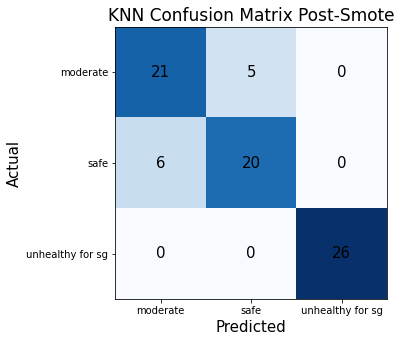

In [472]:
### confusion matrix post-smote
sm_cm_knn=confusion_matrix(y_sm_knn_test, sm_y_pred_knn)

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.set_title('KNN Confusion Matrix Post-Smote', fontsize=17)
ax1.imshow(sm_cm_knn,cmap='Blues')
ax1.grid(False)
ax1.set_xlabel('Predicted', fontsize=15, color='black')
ax1.set_ylabel('Actual', fontsize=15, color='black')
ax1.xaxis.set(ticks=range(3))
ax1.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
ax1.yaxis.set(ticks=range(3))
ax1.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
ax1.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax1.text(j, i, sm_cm_knn[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [473]:
### cross validation scores
sm_cm_knn_cv_scores_train= cross_val_score(sm_knn_model,X_sm_knn_train_scaled,y_sm_knn_train,cv=5,scoring='accuracy')
sm_cm_knn_cv_scores_test= cross_val_score(sm_knn_model,X_sm_knn_test_scaled,y_sm_knn_test,cv=5,scoring='accuracy')

sm_cm_knn_cv_scores_mean_train= sm_cm_knn_cv_scores_train.mean()
sm_cm_knn_cv_scores_std_train= sm_cm_knn_cv_scores_train.std()
sm_cm_knn_cv_scores_mean_test= sm_cm_knn_cv_scores_test.mean()
sm_cm_knn_cv_scores_std_test= sm_cm_knn_cv_scores_test.std()

tp, tn, fp, fn = get_components(sm_cm_knn)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
knnsm_cv_recall, knnsm_cv_precision, knnsm_cv_accuracy=matrix_scores(tp, tn, fp, fn)

print('cross validation results')
print(sm_cm_knn_cv_scores_train)
print(sm_cm_knn_cv_scores_test)
print('Cross validation scores:')
print ('mean accuracy of KNN (post-smote train set) is: ', round(sm_cm_knn_cv_scores_mean_train,1), '+/-',round(sm_cm_knn_cv_scores_std_train,1))
print ('mean accuracy of KNN (post-smote test set) is: ', round(sm_cm_knn_cv_scores_mean_test,1), '+/-',round(sm_cm_knn_cv_scores_std_test,1))
print ('overall accuracy of KNN (post-smote train set): ', round(knnsm_cv_accuracy,2))
print ('recall is ',round(knnsm_cv_recall,2), 'and precision is', round(knnsm_cv_precision,2))

cross validation results
[0.5106383  0.72340426 0.85106383 0.76595745 0.76086957]
[0.5625 0.75   0.6875 0.8    0.6   ]
Cross validation scores:
mean accuracy of KNN (post-smote train set) is:  0.7 +/- 0.1
mean accuracy of KNN (post-smote test set) is:  0.7 +/- 0.1
overall accuracy of KNN (post-smote train set):  0.91
recall is  0.86 and precision is 0.86


Using the smote method on the dataset prior to KNN modeling helped improving the accuracy score and the consistency of the cross validation results while allowing the model to classify correctly the minority class 'unhealthy for sensitive groups'.

In [474]:
knn_rows=pd.DataFrame(data={'Model Type': ['K Nearest Neighbor (train)','K Nearest Neighbor (test)', 'K Nearest Neighbor (post-smote train)','K Nearest Neighbor (post-smote test)'],
                            'R2':['NA','NA','NA','NA'], 'MAE':['NA','NA','NA','NA'],
                            'Accuracy(cv)':[round(cm_knn_cv_scores_mean_train,2),round(cm_knn_cv_scores_mean_test,2),round(sm_cm_knn_cv_scores_mean_train,2),round(sm_cm_knn_cv_scores_mean_test,2)],
                            'Accuracy':['NA',round(knn_cv_accuracy,2),'NA',round(knnsm_cv_accuracy,2)],
                            'Recall':['NA',round(knn_cv_recall,2),'NA',round(knnsm_cv_recall,2)],
                            'Precision':['NA',round(knn_cv_precision,2),'NA',round(knnsm_cv_precision,2)],
                            'Nota Bene':['cannot identify minority class','cannot identify minority class','minority class overfitted','minority class overfitted']}, index=[0,1,2,3])
records=records.append(knn_rows)

<a class="anchor" id="section4_1_6"></a>
### 4.1.6. SVM with RBF Kernel
Support Vector Machine is a powerful classification machine learning method. The multiclass support is handled according to a one-vs-one scheme(decision_function_shape='ovo'). Like for SVR, optimum values for C and gamma need to be determined. Because the dataset is imbalanced, I will be using class_weight='balanced'.

In [475]:
### X and y for SVM
X_rio_svm=cat_riopa.drop(columns='aqi_pm25_in', inplace=False)
y_rio_svm= cat_riopa[['aqi_pm25_in']]

### create stratified training and testing sets from X and y
skf_svm = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_svm.get_n_splits(X_rio_svm, y_rio_svm)

for train_index, test_index in skf_svm.split(X_rio_svm, y_rio_svm):
    X_rio_svm_train, X_rio_svm_test = X_rio_svm.iloc[train_index], X_rio_svm.iloc[test_index]
    y_rio_svm_train, y_rio_svm_test = y_rio_svm.iloc[train_index], y_rio_svm.iloc[test_index]

### scale X_train, X_test
svm_scaler=RobustScaler()
X_rio_svm_train_scaled=svm_scaler.fit_transform(X_rio_svm_train)
X_rio_svm_test_scaled=svm_scaler.transform(X_rio_svm_test)

print(X_rio_svm.shape, y_rio_svm.shape)
print(X_rio_svm_train.shape, X_rio_svm_test.shape, y_rio_svm_train.shape, y_rio_svm_test.shape)
print(X_rio_svm_train_scaled.shape, X_rio_svm_test_scaled.shape )

(186, 21) (186, 1)
(140, 21) (46, 21) (140, 1) (46, 1)
(140, 21) (46, 21)


In [476]:
##### cross validation with gridsearch
## set the parameter 
c_range_svm=10.**np.arange(-3,8)
gamma_range_svm=10.**np.arange(-5,4)

sk_fold_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters_svm={'C': c_range_svm,  'gamma': gamma_range_svm,}

## fill GridSearchCV and fit
grid_svm= GridSearchCV(estimator=SVC(class_weight='balanced',decision_function_shape='ovo', kernel='rbf'), param_grid= parameters_svm, scoring='accuracy', cv=sk_fold_svm)
grid_svm.fit(X_rio_svm_train_scaled, y_rio_svm_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=SVC(class_weight='balanced',
                           decision_function_shape='ovo'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
             scoring='accuracy')

In [477]:
##### visualize the results 
## store the cross validation results in a dataframe
svm_cv_res1=grid_svm.cv_results_
svm_cv_res1_df=pd.DataFrame(svm_cv_res1)
print('The accuracy of the Multi-class Logistic Regression is:', round(svm_cv_res1_df.mean_test_score.max(),2))
print('The best estimators for the Multi-class Logistic Regression are:',svm_cv_res1_df.loc[svm_cv_res1_df.rank_test_score==1])

The accuracy of the Multi-class Logistic Regression is: 0.81
The best estimators for the Multi-class Logistic Regression are:     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
49       0.001599      0.000489         0.000600        0.000490     100   
58       0.001399      0.000490         0.000600        0.000490    1000   
67       0.001599      0.000490         0.000400        0.000490   10000   
76       0.001399      0.000490         0.000600        0.000490  100000   
85       0.001799      0.000400         0.000600        0.000490   1e+06   
94       0.001522      0.000449         0.000815        0.000408   1e+07   

   param_gamma                           params  split0_test_score  \
49         0.1       {'C': 100.0, 'gamma': 0.1}           0.785714   
58         0.1      {'C': 1000.0, 'gamma': 0.1}           0.785714   
67         0.1     {'C': 10000.0, 'gamma': 0.1}           0.785714   
76         0.1    {'C': 100000.0, 'gamma': 0.1}           0.7

In [478]:
### Test the best parameters
svm_model=SVC(class_weight='balanced',decision_function_shape='ovo', kernel='rbf', C=10000000.0, gamma=0.1, random_state=13) 

svm_model.fit(X_rio_svm_train_scaled, y_rio_svm_train)
y_pred_svm=svm_model.predict(X_rio_svm_test_scaled)
svm_score=svm_model.score(X_rio_svm_test_scaled,y_rio_svm_test)
print('The prediction accuracy of the Multiclass Logistic regression model is:', round(svm_score,2))

The prediction accuracy of the Multiclass Logistic regression model is: 0.83


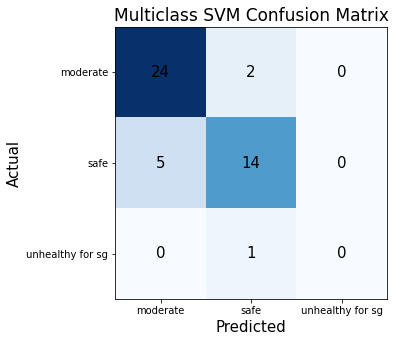

In [479]:
### confusion matrix
cm_svm=confusion_matrix(y_rio_svm_test,y_pred_svm)

fig, ax2 = plt.subplots(figsize=(5, 5))
ax2.set_title('Multiclass SVM Confusion Matrix', fontsize=17)
ax2.imshow(cm_svm,cmap='Blues')
ax2.grid(False)
ax2.set_xlabel('Predicted', fontsize=15, color='black')
ax2.set_ylabel('Actual', fontsize=15, color='black')
ax2.xaxis.set(ticks=range(3))
ax2.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
ax2.yaxis.set(ticks=range(3))
ax2.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
ax2.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax2.text(j, i, cm_svm[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

Like other model, SVM predicts the class 'safe' and 'moderate' with great accuracy (0.85) but it is not able to identify the minority class 'unhealthy for sensitive groups' despite setting SVM with multiclass and imbalanced support parameters. Let's try SVM on the dataset after rebalancing with SMOTE.

In [480]:
### balance classes with Smote()
smo_svm = SMOTE(k_neighbors =3, random_state=13)
X_sm_svm, y_sm_svm = smo_svm.fit_resample(X_rio_svm,y_rio_svm)

### create stratified training and testing sets from X and y
skf_smsvm = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_smsvm.get_n_splits(X_sm_svm, y_sm_svm)

for train_index, test_index in skf_log.split(X_sm_svm, y_sm_svm):
    X_sm_svm_train, X_sm_svm_test = X_sm_svm.iloc[train_index], X_sm_svm.iloc[test_index]
    y_sm_svm_train, y_sm_svm_test = y_sm_svm.iloc[train_index], y_sm_svm.iloc[test_index]

### scale X_train, X_test
sm_svm_scaler=RobustScaler()
X_sm_svm_train_scaled=svm_scaler.fit_transform(X_sm_svm_train)
X_sm_svm_test_scaled=svm_scaler.transform(X_sm_svm_test)

print(X_sm_svm.shape, y_sm_svm.shape)
print(X_sm_svm_train.shape, X_sm_svm_test.shape, y_sm_svm_train.shape, y_sm_svm_test.shape)
print(X_sm_svm_train_scaled.shape, X_sm_svm_test_scaled.shape )

(312, 21) (312, 1)
(234, 21) (78, 21) (234, 1) (78, 1)
(234, 21) (78, 21)


In [481]:
##### cross validation with gridsearch (post-smote)
## set the parameter 
c_range_svm=10.**np.arange(-3,8)
gamma_range_svm=10.**np.arange(-5,4)

sk_fold_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters_svm={'C': c_range_svm,  'gamma': gamma_range_svm,}

## fill GridSearchCV and fit
grid_smsvm= GridSearchCV(estimator=SVC(class_weight='balanced',decision_function_shape='ovo', kernel='rbf'), param_grid= parameters_svm, scoring='accuracy', cv=sk_fold_svm)
grid_smsvm.fit(X_sm_svm_train_scaled, y_sm_svm_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
             estimator=SVC(class_weight='balanced',
                           decision_function_shape='ovo'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
             scoring='accuracy')

In [482]:
##### visualize the results 
## store the cross validation results in a dataframe
smsvm_cv_res1=grid_smsvm.cv_results_
smsvm_cv_res1_df=pd.DataFrame(smsvm_cv_res1)
print('The accuracy of the Multi-class Logistic Regression is:', round(smsvm_cv_res1_df.mean_test_score.max(),2))
print('The best estimators for the Multi-class Logistic Regression are:',smsvm_cv_res1_df.loc[smsvm_cv_res1_df.rank_test_score==1])

The accuracy of the Multi-class Logistic Regression is: 0.91
The best estimators for the Multi-class Logistic Regression are:     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
41       0.002799      0.000400         0.000800        0.000400      10   
50       0.002997      0.000630         0.000801        0.000400     100   
59       0.002798      0.000400         0.000799        0.000746    1000   
68       0.003201      0.000398         0.000197        0.000394   10000   
77       0.002731      0.000645         0.000600        0.000490  100000   
86       0.002916      0.000512         0.000613        0.000474   1e+06   
95       0.002798      0.000400         0.000600        0.000490   1e+07   

   param_gamma                           params  split0_test_score  \
41           1        {'C': 10.0, 'gamma': 1.0}           0.893617   
50           1       {'C': 100.0, 'gamma': 1.0}           0.893617   
59           1      {'C': 1000.0, 'gamma': 1.0}        

In [483]:
### Test the best parameters
smsvm_model=SVC(class_weight='balanced',decision_function_shape='ovo', kernel='rbf', C=10000000.0, gamma=1, random_state=13) 

smsvm_model.fit(X_sm_svm_train_scaled, y_sm_svm_train)
y_pred_smsvm=smsvm_model.predict(X_sm_svm_test_scaled)
smsvm_score=smsvm_model.score(X_sm_svm_test_scaled,y_sm_svm_test)
print('The prediction accuracy of the Multiclass Logistic regression model is:', round(smsvm_score,2))

The prediction accuracy of the Multiclass Logistic regression model is: 0.82


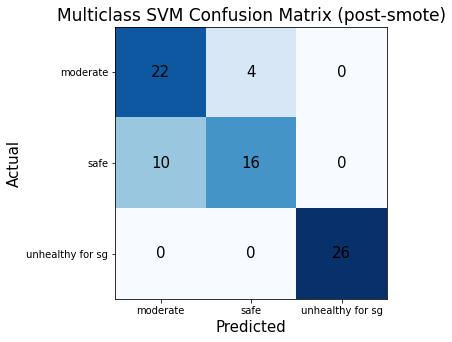

In [484]:
### confusion matrix
cm_smsvm=confusion_matrix(y_sm_svm_test,y_pred_smsvm)

fig, ax2 = plt.subplots(figsize=(5, 5))
ax2.set_title('Multiclass SVM Confusion Matrix (post-smote)', fontsize=17)
ax2.imshow(cm_smsvm,cmap='Blues')
ax2.grid(False)
ax2.set_xlabel('Predicted', fontsize=15, color='black')
ax2.set_ylabel('Actual', fontsize=15, color='black')
ax2.xaxis.set(ticks=range(3))
ax2.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
ax2.yaxis.set(ticks=range(3))
ax2.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
ax2.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax2.text(j, i, cm_smsvm[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [485]:
### cross validation scores
svm_cv_scores_train= cross_val_score(svm_model,X_rio_svm_train_scaled,y_rio_svm_train,cv=5,scoring='accuracy')
svm_cv_scores_test= cross_val_score(svm_model,X_rio_svm_test_scaled,y_rio_svm_test,cv=5,scoring='accuracy')

svm_cv_scores_mean_train= svm_cv_scores_train.mean()
svm_cv_scores_std_train= svm_cv_scores_train.std()
svm_cv_scores_mean_test= svm_cv_scores_test.mean()
svm_cv_scores_std_test= svm_cv_scores_test.std()

smsvm_cv_scores_train= cross_val_score(smsvm_model,X_sm_svm_train_scaled,y_sm_svm_train,cv=5,scoring='accuracy')
smsvm_cv_scores_test= cross_val_score(smsvm_model,X_sm_svm_test_scaled,y_sm_svm_test,cv=5,scoring='accuracy')

smsvm_cv_scores_mean_train= smsvm_cv_scores_train.mean()
smsvm_cv_scores_std_train= smsvm_cv_scores_train.std()
smsvm_cv_scores_mean_test= smsvm_cv_scores_test.mean()
smsvm_cv_scores_std_test= smsvm_cv_scores_test.std()


tp, tn, fp, fn = get_components(cm_svm)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
svm_cv_recall, svm_cv_precision, svm_cv_accuracy=matrix_scores(tp, tn, fp, fn)

tp, tn, fp, fn = get_components(cm_smsvm)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
smsvm_cv_recall, smsvm_cv_precision, smsvm_cv_accuracy=matrix_scores(tp, tn, fp, fn)

print('Cross validation scores:')
print ('mean accuracy of multiclass SVM (train set, pre-smote) is: ', round(svm_cv_scores_mean_train,2), '+/-',round(svm_cv_scores_std_train,2))
print ('mean accuracy of multiclass SVM (test set, pre-smote) is: ', round(svm_cv_scores_mean_test,2), '+/-',round(svm_cv_scores_std_test,2))
print ('mean accuracy of multiclass SVM (train set, post-smote) is: ', round(smsvm_cv_scores_mean_train,2), '+/-',round(smsvm_cv_scores_std_train,2))
print ('mean accuracy of multiclass SVM (test set, post-smote) is: ', round(smsvm_cv_scores_mean_test,2), '+/-',round(smsvm_cv_scores_std_test,2))

print ('overall accuracy of multiclass SVM (pre-smote): ', round(svm_cv_accuracy,2))
print ('recall is ',round(svm_cv_recall,2), 'and precision is', round(svm_cv_precision,2))
print ('overall accuracy of multiclass SVM (post-smote): ', round(smsvm_cv_accuracy,2))
print ('recall is ',round(smsvm_cv_recall,2), 'and precision is', round(smsvm_cv_precision,2))

Cross validation scores:
mean accuracy of multiclass SVM (train set, pre-smote) is:  0.62 +/- 0.06
mean accuracy of multiclass SVM (test set, pre-smote) is:  0.48 +/- 0.08
mean accuracy of multiclass SVM (train set, post-smote) is:  0.79 +/- 0.07
mean accuracy of multiclass SVM (test set, post-smote) is:  0.68 +/- 0.06
overall accuracy of multiclass SVM (pre-smote):  0.88
recall is  0.83 and precision is 0.83
overall accuracy of multiclass SVM (post-smote):  0.88
recall is  0.82 and precision is 0.82


Rebalancing with smote improved the predictions from the SVM model on both train and test set with accuracies of 0.8 and 0.7, respectively, and allowed the model to identify the minority group 'unhealthy for sensitive groups'.

In [486]:
svm_rows=pd.DataFrame(data={'Model Type': ['SVM (train)','SVM (test)', 'SVM (post-smote train)','SVM (post-smote test)'],
                            'R2':['NA','NA','NA','NA'], 'MAE':['NA','NA','NA','NA'],
                            'Accuracy(cv)':[round(svm_cv_scores_mean_train,2),round(svm_cv_scores_mean_test,2),round(smsvm_cv_scores_mean_train,2),round(smsvm_cv_scores_mean_test,2)],
                            'Accuracy':['NA',round(svm_cv_accuracy,2),'NA',round(smsvm_cv_accuracy,2)],
                            'Recall':['NA',round(svm_cv_recall,2),'NA',round(smsvm_cv_recall,2)],
                            'Precision':['NA',round(svm_cv_precision,2),'NA',round(smsvm_cv_precision,2)],
                            'Nota Bene':['cannot identify minority class','cannot identify minority class','minority class overfitted','minority class overfitted']}, index=[0,1,2,3])
records=records.append(svm_rows)

<a class="anchor" id="section4_1_7"></a>
### 4.1.7. XGBoost for Classification
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. The advantage of XGBoost over other Gradient Boosting models is that it has regularization options, built-in cross-validation, tree pruning, and parallel processing to boost performance. It has a lot of hyperparameters to chose from to tune the model towards higher performance. The best is to start with the basics and find the best n_estimators, max_depth. If I select XGBoost as my final model I will dive deeper into the parameter selection.

In [487]:
### X and y for XGBoostClassifier
X_rio_xgbc=cat_riopa.drop(columns='aqi_pm25_in', inplace=False)
y_rio_xgbc= cat_riopa[['aqi_pm25_in']]

### create stratified training and testing sets from X and y
skf_xgbc = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
skf_xgbc.get_n_splits(X_rio_xgbc, y_rio_xgbc)

for train_index, test_index in skf_xgbc.split(X_rio_xgbc, y_rio_xgbc):
    X_rio_xgbc_train, X_rio_xgbc_test = X_rio_xgbc.iloc[train_index], X_rio_xgbc.iloc[test_index]
    y_rio_xgbc_train, y_rio_xgbc_test = y_rio_xgbc.iloc[train_index], y_rio_xgbc.iloc[test_index]

### scale X_train, X_test
xgbc_scaler=RobustScaler()
X_rio_xgbc_train_scaled=xgbc_scaler.fit_transform(X_rio_xgbc_train)
X_rio_xgbc_test_scaled=xgbc_scaler.transform(X_rio_xgbc_test) 

### modeling 
xgbc_model=xgb.XGBClassifier(n_estimators=1000, objective= 'multi:softmax', seed=13)
xgbc_model.fit(X_rio_xgbc_train_scaled,y_rio_xgbc_train)
y_pred_xgbc = xgbc_model.predict(X_rio_xgbc_test_scaled)

print('the accuracy score of XGBoost is:', round(accuracy_score(y_rio_xgbc_test, y_pred_xgbc),2))

the accuracy score of XGBoost is: 0.87


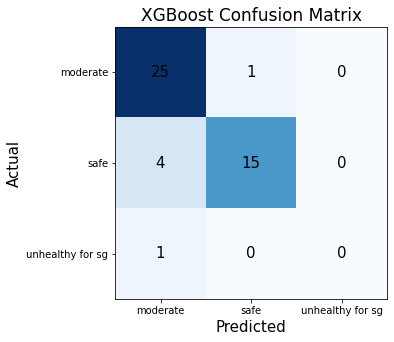

In [488]:
### confusion matrix
cm_xgbc=confusion_matrix(y_rio_xgbc_test, y_pred_xgbc)

fig, axk = plt.subplots(figsize=(5, 5))
axk.set_title('XGBoost Confusion Matrix', fontsize=17)
axk.imshow(cm_xgbc,cmap='Blues')
axk.grid(False)
axk.set_xlabel('Predicted', fontsize=15, color='black')
axk.set_ylabel('Actual', fontsize=15, color='black')
axk.xaxis.set(ticks=range(3))
axk.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
axk.yaxis.set(ticks=range(3))
axk.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
axk.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        axk.text(j, i, cm_xgbc[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [489]:
#### SMOTE

### balance classes with Smote()
smo_xgbc = SMOTE(k_neighbors =3, random_state=13)
X_sm_xgbc, y_sm_xgbc = smo_knn.fit_resample(X_rio_knn,y_rio_knn)

### create stratified training and testing sets from X and y
sm_skf_xgbc = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
sm_skf_xgbc.get_n_splits(X_sm_xgbc, y_sm_xgbc)

for train_index, test_index in skf_xgbc.split(X_sm_xgbc, y_sm_xgbc):
    X_sm_xgbc_train, X_sm_xgbc_test = X_sm_xgbc.iloc[train_index], X_sm_xgbc.iloc[test_index]
    y_sm_xgbc_train, y_sm_xgbc_test = y_sm_xgbc.iloc[train_index], y_sm_xgbc.iloc[test_index]

### scale X_train, X_test
sm_xgbc_scaler=RobustScaler()
X_sm_xgbc_train_scaled=sm_xgbc_scaler.fit_transform(X_sm_xgbc_train)
X_sm_xgbc_test_scaled=sm_xgbc_scaler.transform(X_sm_xgbc_test) 

### modeling
sm_xgbc_model=xgb.XGBClassifier(n_estimators=1000, objective= 'multi:softmax', seed=13)
sm_xgbc_model.fit(X_sm_xgbc_train_scaled,y_sm_xgbc_train)
sm_y_pred_xgbc = sm_xgbc_model.predict(X_sm_xgbc_test_scaled)
print('the accuracy score of XGBoost post-smote is:', round(accuracy_score(y_sm_xgbc_test, sm_y_pred_xgbc),2))

the accuracy score of XGBoost post-smote is: 0.86


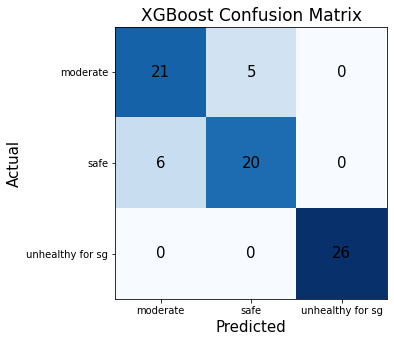

In [490]:
### confusion matrix
smcm_xgbc=confusion_matrix(y_sm_xgbc_test, sm_y_pred_xgbc)

fig, axk = plt.subplots(figsize=(5, 5))
axk.set_title('XGBoost Confusion Matrix', fontsize=17)
axk.imshow(smcm_xgbc,cmap='Blues')
axk.grid(False)
axk.set_xlabel('Predicted', fontsize=15, color='black')
axk.set_ylabel('Actual', fontsize=15, color='black')
axk.xaxis.set(ticks=range(3))
axk.set_xticklabels([ 'moderate', 'safe','unhealthy for sg'])
axk.yaxis.set(ticks=range(3))
axk.set_yticklabels([ 'moderate','safe', 'unhealthy for sg'])
axk.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        axk.text(j, i, smcm_xgbc[i, j], ha='center', va='center', color='black', fontsize=15)
plt.show()

In [491]:
### cross validation scores
xgbc_cv_scores_train= cross_val_score(xgbc_model,X_rio_xgbc_train_scaled,y_rio_xgbc_train,cv=5,scoring='accuracy')
xgbc_cv_scores_test= cross_val_score(xgbc_model,X_rio_xgbc_test_scaled,y_rio_xgbc_test,cv=5,scoring='accuracy')

xgbc_cv_scores_mean_train= xgbc_cv_scores_train.mean()
xgbc_cv_scores_std_train= xgbc_cv_scores_train.std()
xgbc_cv_scores_mean_test= xgbc_cv_scores_test.mean()
xgbc_cv_scores_std_test= xgbc_cv_scores_test.std()

smxgbc_cv_scores_train= cross_val_score(sm_xgbc_model,X_sm_xgbc_train_scaled,y_sm_xgbc_train,cv=5,scoring='accuracy')
smxgbc_cv_scores_test= cross_val_score(sm_xgbc_model,X_sm_xgbc_test_scaled,y_sm_xgbc_test,cv=5,scoring='accuracy')

smxgbc_cv_scores_mean_train= smxgbc_cv_scores_train.mean()
smxgbc_cv_scores_std_train= smxgbc_cv_scores_train.std()
smxgbc_cv_scores_mean_test= smxgbc_cv_scores_test.mean()
smxgbc_cv_scores_std_test= smxgbc_cv_scores_test.std()


tp, tn, fp, fn = get_components(cm_xgbc)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
xgbc_cv_recall, xgbc_cv_precision, xgbc_cv_accuracy=matrix_scores(tp, tn, fp, fn)

tp, tn, fp, fn = get_components(smcm_xgbc)
tp, tn, fp, fn=sum_components(tp, tn, fp, fn)
smxgbc_cv_recall, smxgbc_cv_precision, smxgbc_cv_accuracy=matrix_scores(tp, tn, fp, fn)

print('Cross validation scores:')
print ('mean accuracy of multiclass XGBoost (train set, pre-smote) is: ', round(xgbc_cv_scores_mean_train,1), '+/-',round(xgbc_cv_scores_std_train,1))
print ('mean accuracy of multiclass XGBoost (test set, pre-smote) is: ', round(xgbc_cv_scores_mean_test,1), '+/-',round(xgbc_cv_scores_std_test,1))
print ('mean accuracy of multiclass XGBoost (train set, post-smote) is: ', round(smxgbc_cv_scores_mean_train,1), '+/-',round(smxgbc_cv_scores_std_train,1))
print ('mean accuracy of multiclass XGBoost (test set, post-smote) is: ', round(smxgbc_cv_scores_mean_test,1), '+/-',round(smxgbc_cv_scores_std_test,1))
print ('overall accuracy of multiclass XGBoost (pre-smote): ', round(xgbc_cv_accuracy,2))
print ('recall is ',round(xgbc_cv_recall,2), 'and precision is', round(xgbc_cv_precision,2))
print ('overall accuracy of multiclass XGBoost (post-smote): ', round(smxgbc_cv_accuracy,2))
print ('recall is ',round(smxgbc_cv_recall,2), 'and precision is', round(smxgbc_cv_precision,2))

Cross validation scores:
mean accuracy of multiclass XGBoost (train set, pre-smote) is:  0.7 +/- 0.1
mean accuracy of multiclass XGBoost (test set, pre-smote) is:  nan +/- nan
mean accuracy of multiclass XGBoost (train set, post-smote) is:  0.8 +/- 0.1
mean accuracy of multiclass XGBoost (test set, post-smote) is:  0.7 +/- 0.1
overall accuracy of multiclass XGBoost (pre-smote):  0.91
recall is  0.87 and precision is 0.87
overall accuracy of multiclass XGBoost (post-smote):  0.91
recall is  0.86 and precision is 0.86


In [492]:
xgbc_rows=pd.DataFrame(data={'Model Type': ['XGBoost Classifier (train)','XGBoost Classifier (test)', 'XGBoost Classifier (post-smote train)','XGBoost Classifier (post-smote test)'],
                            'R2':['NA','NA','NA','NA'], 'MAE':['NA','NA','NA','NA'],
                            'Accuracy(cv)':[round(xgbc_cv_scores_mean_train,2),round(xgbc_cv_scores_mean_test,2),round(smxgbc_cv_scores_mean_train,2),round(smxgbc_cv_scores_mean_test,2)],
                            'Accuracy':['NA',round(xgbc_cv_accuracy,2),'NA',round(smxgbc_cv_accuracy,2)],
                            'Recall':['NA',round(xgbc_cv_recall,2),'NA',round(smxgbc_cv_recall,2)],
                            'Precision':['NA',round(xgbc_cv_precision,2),'NA',round(smxgbc_cv_precision,2)],
                            'Nota Bene':['cannot identify minority class','cannot identify minority class','minority class overfitted','minority class overfitted']}, index=[0,1,2,3])

records=records.append(xgbc_rows)

<a class="anchor" id="section4_1_8"></a>
### 4.1.8. XGBoost for Regression
XGBoost can be used also for regression.

In [493]:
### X and y for XGBoost Regression
### create X and y (non transformed)
X_rio_xgbr=feat_rio_all[['pm25_ou','ambient_temp_c_in', 'airexrate_in','ambient_rh_in', 
                    'rh_ou', 'dust_sand','rain_prcp', 'smoke_haze', 'temp_max',
                    'thunder', 'wind_avgspeed','wind_fastest_2min', 'fog_all',
                    'snow_all', 'rain_all', 'wind_dmg', 'wind_all',
                    'landuse_main_Residential', 'landuse_near_Park', 'landuse_near_Residential']]
y_rio_xgbr=feat_rio_all[['pm25_in']]


### create training and testing sets from X and y
X_rio_xgbr_train, X_rio_xgbr_test, y_rio_xgbr_train, y_rio_xgbr_test = train_test_split(X_rio_xgbr, y_rio_xgbr, test_size = 0.3, random_state= 13)

### scale
xgbr_scaler=RobustScaler()
X_rio_xgbr_train_scaled=xgbr_scaler.fit_transform(X_rio_xgbr_train)
X_rio_xgbr_test_scaled=xgbr_scaler.transform(X_rio_xgbr_test) 

### train
xgbr_reg = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', n_estimators=1000, max_depth=3, seed=13)
xgbr_reg.fit(X_rio_xgbr_train_scaled, y_rio_xgbr_train)
y_pred_xgbr = xgbr_reg.predict(X_rio_xgbr_test_scaled)

xgbr_mae=round(mean_absolute_error(y_rio_xgbr_test, y_pred_xgbr),2)
xgbr_mse=round(mean_squared_error(y_rio_xgbr_test, y_pred_xgbr),2)
# Compute mse, mae
print("MSE of XGBoost Regressor :", xgbr_mse )
print("MAE of XGBoost Regressor :", xgbr_mae )

MSE of XGBoost Regressor : 57.49
MAE of XGBoost Regressor : 4.99


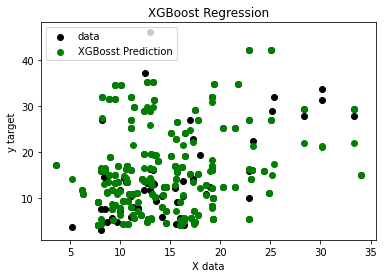

In [494]:
X_rio_xgbr_w_scaled=xgbr_scaler.transform(X_rio_xgbr)
y_pred_wholexgbr=xgbr_reg.predict(X_rio_xgbr_w_scaled)
pl.scatter(X_rio_xgbr[['pm25_ou']], y_rio_xgbr, c='k', label='data')
pl.scatter(X_rio_xgbr[['pm25_ou']], y_pred_wholexgbr, c='g', label='XGBosst Prediction')
pl.xlabel('X data')
pl.ylabel('y target')
pl.title('XGBoost Regression')
pl.legend()
pl.show()

In [495]:
### Evaluate model quality using built-in cv
## create the Dmatrix
rio_dmatrix = xgb.DMatrix(data=X_rio_xgbr, label=y_rio_xgbr)

### set parameters
xgbr_parameters = {'objective':'reg:squarederror', 'booster':'gbtree', 'n_estimators':1000, 'max_depth':7, 'early_stopping_rounds':10, 'colsample_bytree': 0.79,'subsample_bytree': 0.8}

# cross-validation with xbg.cv
xgbr_cv_results = xgb.cv(dtrain=rio_dmatrix, params=xgbr_parameters , nfold=5, num_boost_round=10, metrics='mae', as_pandas=True, seed=13)

print(xgbr_cv_results)

[14:00:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds, n_estimators, subsample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds, n_estimators, subsample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds,

XGBoost Regression works well with the dataset with minor tuning of parameters and shows the lowest MAE for train (1.5) and test (5).

In [496]:
xgbr_rows=pd.DataFrame(data={'Model Type': ['XGBoost Regressor (train)','XGBoost Regressor (test)'],
                            'R2':['NA','NA'], 'MAE':[1.4,5],
                            'Accuracy(cv)':['NA','NA'],
                            'Accuracy':['NA','NA'],
                            'Recall':['NA','NA'],
                            'Precision':['NA','NA'],
                            'Nota Bene':['works, need tuning','works, need tuning']}, index=[0,1])

records=records.append(xgbr_rows)

In [497]:
### gridsearch
# Create the parameter grid: gbm_param_grid
#xgbr_param_grid = {'colsample_bytree': 0.79, 'n_estimators': np.arange(10,1010,50),'max_depth': np.arange(2,15,1)}

# Instantiate the regressor: gbm
#xgbr_search = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', seed=13)

# Perform grid search: grid_mse
#grid_xgbr_search = GridSearchCV(param_grid=xgbr_param_grid, estimator=xgbr_search,  scoring='neg_mean_absolute_error', cv=5, verbose=1) 
              
# Fit grid_mse to the data
#grid_xgbr_search.fit(X_rio_xgbr_train_scaled, y_rio_xgbr_train)

# Print the best parameters and lowest RMSE
#print("Best parameters found: ", grid_xgbr_search.best_params_)
#print("Lowest RMSE found: ", np.sqrt(np.abs(grid_xgbr_search.best_score_)))



In [498]:
records.reset_index(inplace=True)
records.drop(columns='index', inplace=True)

<a class="anchor" id="section4_1_9"></a>
### 4.1.9. Riopa's Final Model


In [499]:
regression_table=records.iloc[[0,1,2,3,4,5,6,7,24,25]]
regression_table.drop(columns=['Accuracy(cv)','Accuracy','Recall', 'Precision'], inplace=True)
regression_table

,Model Type,R2,MAE,Nota Bene
0,Linear Regression,0.02,NA,Does not fit
1,Linear Regression OLS,0.02,NA,Does not fit
2,Multi-linear Regression (formula OLS),0.19,NA,Does not fit
3,Multi-linear Regression (formula OLS),0.24,NA,Does not fit
4,SVR (train),0.99,0.23,Model overfits train set
5,SVR (test),0.38,4.84,Model overfits train set
6,SVR (cv train),0.54,-4.22,low performance
7,SVR (cv test),0.18,-6.64,low performance
24,XGBoost Regressor (train),NA,1.4,"works, need tuning"
25,XGBoost Regressor (test),NA,5,"works, need tuning"


In [500]:
classification_table=records.iloc[8:24]
classification_table.drop(columns=['R2','MAE'], inplace=True)
classification_table

,Model Type,Accuracy(cv),Accuracy,Recall,Precision,Nota Bene
8,Logistic Regression (train),0.692857,NA,NA,NA,cannot identify minority class
9,Logistic Regression (test),0.524444,0.84,0.76,0.76,cannot identify minority class
10,Logistic Regression (post-smote train),0.790842,NA,NA,NA,minority class overfitted
11,Logistic Regression (post-smote test),0.73,0.9,0.85,0.85,minority class overfitted
12,K Nearest Neighbor (train),0.62,NA,NA,NA,cannot identify minority class
13,K Nearest Neighbor (test),0.32,0.9,0.85,0.85,cannot identify minority class
14,K Nearest Neighbor (post-smote train),0.72,NA,NA,NA,minority class overfitted
15,K Nearest Neighbor (post-smote test),0.68,0.91,0.86,0.86,minority class overfitted
16,SVM (train),0.62,NA,NA,NA,cannot identify minority class
17,SVM (test),0.48,0.88,0.83,0.83,cannot identify minority class


The best models to predict indoor PM 2.5 from outdoor PM 2.5 and other features are:
- XGBoost Classifier (recall=0.86,precision=0.86, accuracy=0.9).
- XGBoost Regression (MAE train=1.4, MAE Test=5, no overfitting).

The final Riopa's model will be built with XGBoost Regressor, because the classifier was not able to identify the minority class without having to alter the dataset. I combined xgb.cv and GridSearchCV  to determine the optimum set of parameters. Below is some samples of the code I used.

In [501]:
rio_mx=rio_dmatrix

In [502]:
### final parameter grid
tree_parameters = {'objective':'reg:squarederror',
                   'booster':'gbtree',
                   'eta':0.1,
                   'n_estimators':2000,
                   'max_depth':5,
                   'subsample': 0.7,
                   'colsample_bytree': 1}

In [503]:
### Evaluate model quality using built-in cv
## create the Dmatrix

# cross-validation with xbg.cv
xgbr_cv_rmse = xgb.cv(dtrain=rio_dmatrix, params=tree_parameters , nfold=5, num_boost_round=100, metrics='rmse', as_pandas=True, seed=13)
rmse_final=xgbr_cv_rmse['test-rmse-mean'].tail().values[-1]
xgbr_cv_mae = xgb.cv(dtrain=rio_dmatrix, params=tree_parameters , nfold=5, num_boost_round=100, metrics='mae', as_pandas=True, seed=13)
mae_final=xgbr_cv_mae['test-mae-mean'].tail().values[-1]
print('Riopa model final RMSE:',round(rmse_final,2))
print('Riopa model final MAE:',round(mae_final,2))

[14:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [504]:
# Plot the feature importances
xgb_final = xgb.train(dtrain=rio_mx, params=tree_parameters , num_boost_round=100)
#xgb.plot_importance(xgb_feat)

[14:00:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<AxesSubplot:ylabel='Feature'>

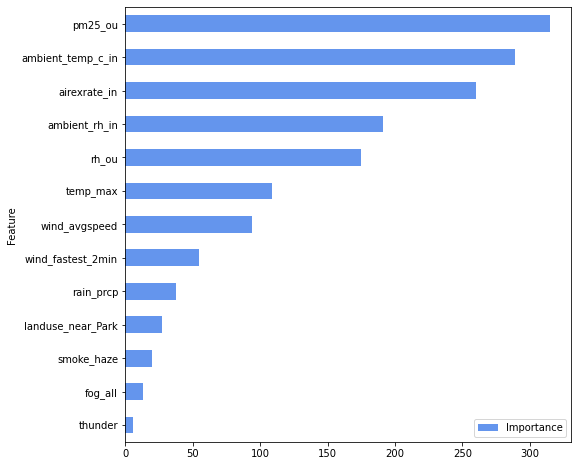

In [505]:
important_features = xgb_final.get_fscore()
impfeat = pd.DataFrame({'Importance': list(important_features.values()), 'Feature': list(important_features.keys())})
impfeat.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')

The tuned XGBoost Regressor model is able to predict indoor PM 2.5 concentrations from outdoor PM 2.5 concetrations and indoor and outdoor environmental data, with a MAE of 4.4 and a RMSE of 6.8. The MAE falls in the lower side of the range of expected measurement error from a particluate matter sensor (see 'declared accuracy of +/- 10ug/m3) [https://www.nature.com/articles/s41598-019-43716-3/tables/1].

The major features of importance are:
- first (and unsurprisingly) the outdoor concentration of PM 2.5.
- second the ambient indoor temperature.
- third the air exchange rate between inside the homeand outside.
- to a lesser extent, humidity , both indoor and outdoor.

The minor features of importance are linked to outdoor weather and location:maximum temperature, wind,and rain. Land use has little to do in the equation.

To model the indoor PM 2.5 concentrations using output from the model of the outdoor air quality data, I will have to assume or play around with a range of values for the indoor temperature, humidity and air exchange because these parameters are not readily available in the air quality dataset.

<a class="anchor" id="section4_2"></a>
## 4.2. Outdoor Air Quality
This part of the project aims at predicting outdoor air quality in Houston in 2028, taking in to account population growth, land use change, and climate change. 
According to the EDA, using linear or multi-linear regressions would no make sense. Logistic Regression is better suited for the type of the data that SVM (for unstructured data) or KNN (lack multi-class potential) and of course XGBoost will work well with large datasets.
I chose to test the following models:
- Multi-class Logistic Regression.
- XGBoost Classifier.
- XGBoost Regressor.

Before delving into classification models, I need to make sure that my classes are not too much imbalanced, because it was a problem for the indoor-outdoor dataset.

In [506]:
oaq_aqi=['feat_aqi_co', 'feat_aqi_fivepoll', 'feat_aqi_no2', 'feat_aqi_ozno2poll', 'feat_aqi_ozone', 'feat_aqi_pm10', 'feat_aqi_pm25']

In [507]:
feat_aqi_co.aqi_co.unique()

array(['safe', 'moderate'], dtype=object)

In [508]:
### create a function that split dataframes into stratified X,y and train/test sets
def TTS_stratified(df,colname):
    X=df.drop(columns=colname, inplace=False)
    y= df[[colname]]
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X,y,X_train,X_test,y_train,y_test

### create a function which computes the classes weigths in a pandas series
def class_wt(y):
    ccw=compute_class_weight('balanced', np.unique(y), y = np.ravel(y))
    ccw_dc={}
    for k, v in zip(np.unique(y), ccw):
        ccw_dc[k] = round(v,2)
    return ccw_dc

In [509]:
X_ozone_aqi,y_ozone_aqi,X_ozone_aqi_train,X_ozone_aqi_test,y_ozone_aqi_train,y_ozone_aqi_test=TTS_stratified(feat_aqi_ozone,'aqi_ozone')
print(class_wt(y_ozone_aqi))

{'moderate': 2.27, 'safe': 0.22, 'unhealthy': 61.55, 'unhealthy for sensitive groups': 11.31, 'very unhealthy': 1301.37}


In [510]:
X_co_aqi,y_co_aqi,X_co_aqi_train,X_co_aqi_test,y_co_aqi_train,y_co_aqi_test=TTS_stratified(feat_aqi_co,'aqi_co')
print(class_wt(y_co_aqi))

{'moderate': 5059.75, 'safe': 0.5}


In [511]:
X_no2_aqi,y_no2_aqi,X_no2_aqi_train,X_no2_aqi_test,y_no2_aqi_train,y_no2_aqi_test=TTS_stratified(feat_aqi_no2,'aqi_no2')
print(class_wt(y_no2_aqi))

{'moderate': 49.9, 'safe': 0.34, 'unhealthy for sensitive groups': 2370.13}


In [512]:
X_so2_aqi,y_so2_aqi,X_so2_aqi_train,X_so2_aqi_test,y_so2_aqi_train,y_so2_aqi_test=TTS_stratified(feat_aqi_so2,'aqi_so2')
print(class_wt(y_so2_aqi))

{'moderate': 69.32, 'safe': 0.34, 'unhealthy for sensitive groups': 1584.57}


In [513]:
X_pm25_aqi,y_pm25_aqi,X_pm25_aqi_train,X_pm25_aqi_test,y_pm25_aqi_train,y_pm25_aqi_test=TTS_stratified(feat_aqi_pm25,'aqi_pm25')
print(class_wt(y_pm25_aqi))

{'moderate': 0.96, 'safe': 0.34, 'unhealthy': 3171.12, 'unhealthy for sensitive groups': 362.41}


In [514]:
X_pm10_aqi,y_pm10_aqi,X_pm10_aqi_train,X_pm10_aqi_test,y_pm10_aqi_train,y_pm10_aqi_test=TTS_stratified(feat_aqi_pm10,'aqi_pm10')
print(class_wt(y_pm10_aqi))

{'moderate': 9.05, 'safe': 0.53}


Computing the weights shows that there are large imbalances (weights up to 5059) which will definitely impair the classification models. I will therefore drop the idea of a classification model and focus on the XGBoost Regression.

In [515]:
onepoll=[feat_ozone,feat_co, feat_no2,feat_so2,feat_ozone, feat_pm10]

In [516]:
### create a function that split dataframes into sX,y and train/test sets
def TTS(df,colname):
    X=df.drop(columns=colname, inplace=False)
    y= df[[colname]]
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=13)
    return X,y,X_train,X_test,y_train,y_test

In [517]:
### train/test split
X_ozone, y_ozone, X_ozone_train, X_ozone_test, y_ozone_train, y_ozone_test=TTS(feat_ozone,'ozone')
X_co, y_co, X_co_train, X_co_test, y_co_train, y_co_test=TTS(feat_co,'co')
X_no2, y_no2, X_no2_train, X_no2_test, y_no2_train, y_no2_test=TTS(feat_no2,'no2')
X_so2, y_so2, X_so2_train, X_so2_test, y_so2_train, y_so2_test=TTS(feat_so2,'so2')
X_pm25, y_pm25, X_pm25_train, X_pm25_test, y_pm25_train, y_pm25_test=TTS(feat_pm25,'pm25')
X_pm10, y_pm10, X_pm10_train, X_pm10_test, y_pm10_train, y_pm10_test=TTS(feat_pm10,'pm10')

In [518]:
### scale X
ozone_scaler=RobustScaler()
X_ozone_train_scaled=ozone_scaler.fit_transform(X_ozone_train)
X_ozone_test_scaled=ozone_scaler.transform(X_ozone_test)

co_scaler=RobustScaler()
X_co_train_scaled=co_scaler.fit_transform(X_co_train)
X_co_test_scaled=co_scaler.transform(X_co_test)

no2_scaler=RobustScaler()
X_no2_train_scaled=no2_scaler.fit_transform(X_no2_train)
X_no2_test_scaled=no2_scaler.transform(X_no2_test)

so2_scaler=RobustScaler()
X_so2_train_scaled=so2_scaler.fit_transform(X_so2_train)
X_so2_test_scaled=so2_scaler.transform(X_so2_test)

pm25_scaler=RobustScaler()
X_pm25_train_scaled=pm25_scaler.fit_transform(X_pm25_train)
X_pm25_test_scaled=pm25_scaler.transform(X_pm25_test)

pm10_scaler=RobustScaler()
X_pm10_train_scaled=pm10_scaler.fit_transform(X_pm10_train)
X_pm10_test_scaled=pm10_scaler.transform(X_pm10_test)

In [519]:
### function to quickly run a first pass model
### and get mae, rmse
def first_pass_model(X_train_scaled,y_train,X_test_scaled,y_test):
    xgb_aq = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', n_estimators=1000, max_depth=3, seed=13)
    xgb_aq.fit(X_train_scaled, y_train)
    y_pred = xgb_aq.predict(X_test_scaled)
    xgb_aq_mae=round(mean_absolute_error(y_test, y_pred),2)
    xgb_aq_rmse=round(math.sqrt(mean_squared_error(y_test, y_pred)),2)
    return  xgb_aq_mae, xgb_aq_rmse   

In [520]:
poll_list=['ozone','co','no2','so2','pm25','pm10']
ozone_mae, ozone_rmse = first_pass_model(X_ozone_train_scaled, y_ozone_train, X_ozone_test_scaled, y_ozone_test)
co_mae, co_rmse = first_pass_model(X_co_train_scaled, y_co_train, X_co_test_scaled, y_co_test)
no2_mae, no2_rmse = first_pass_model(X_no2_train_scaled, y_no2_train, X_no2_test_scaled, y_no2_test)
so2_mae, so2_rmse = first_pass_model(X_so2_train_scaled, y_so2_train, X_so2_test_scaled, y_so2_test)
pm25_mae, pm25_rmse = first_pass_model(X_pm25_train_scaled, y_pm25_train, X_pm25_test_scaled, y_pm25_test)
pm10_mae, pm10_rmse = first_pass_model(X_pm10_train_scaled, y_pm10_train, X_pm10_test_scaled, y_pm10_test)

In [521]:
mae_list=[ozone_mae,co_mae,no2_mae,so2_mae,pm25_mae,pm10_mae]
rmse_list=[ozone_rmse,co_rmse,no2_rmse,so2_rmse,pm25_rmse,pm10_rmse]

In [522]:
first_pass_scores= pd.DataFrame(list(zip(poll_list,mae_list,rmse_list)), columns=['Pollutant','MAE','RMSE'])

In [523]:
first_pass_scores

,Pollutant,MAE,RMSE
0,ozone,6.67,8.88
1,co,0.10,0.17
2,no2,5.22,7.01
3,so2,2.61,4.64
4,pm25,2.48,3.58
5,pm10,6.98,10.82


For a first pass model without any sort of tuning, the results are quite good. I am going to create and tune a specific model for each pollutant.

In [524]:
### create a function to facilitate
### the cross-validation of tree parameters
### using xgb.cv on the 6 dataframes

def xgb_cross_val(X,poll,tree_params, nfold, boost_round,y):
    dmx=xgb.DMatrix(data=X, label=y)
    rmse_cv = xgb.cv(dtrain=dmx, params=tree_parameters , nfold=nfold, num_boost_round=boost_round, metrics='rmse', as_pandas=True, seed=13)
    rmse=rmse_cv['test-rmse-mean'].tail().values[-1]
    mae_cv= xgb.cv(dtrain=X, params=tree_parameters , nfold=nfold, num_boost_round=boost_round, metrics='mae', as_pandas=True, seed=13)
    mae=xgbr_cv_mae['test-mae-mean'].tail().values[-1]
    return round(mae,2), round(rmse,2)

In [525]:
### preparing DMatrix
ozone_dmx=xgb.DMatrix(data=X_ozone, label=y_ozone)
co_dmx=xgb.DMatrix(data=X_co, label=y_co)
no2_dmx=xgb.DMatrix(data=X_no2, label=y_no2)
so2_dmx=xgb.DMatrix(data=X_so2, label=y_so2)
pm25_dmx=xgb.DMatrix(data=X_pm25, label=y_pm25)
pm10_dmx=xgb.DMatrix(data=X_pm10, label=y_pm10)

In [526]:
### tree parameter example
tree_parameters = {'objective':'reg:squarederror',
                   'booster':'gbtree',
                   'eta':0.1,
                   'n_estimators':2000,
                   'max_depth':5,
                   'subsample': 0.7,
                   'colsample_bytree': 1}

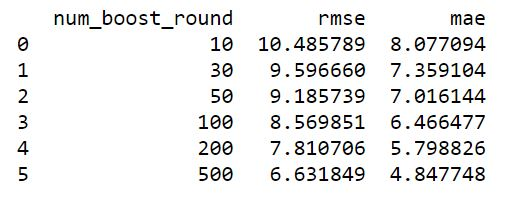

In [527]:
#print(boost_df)
Image(filename = "BoostRounds_ozone.jpg", width=300, height=270)

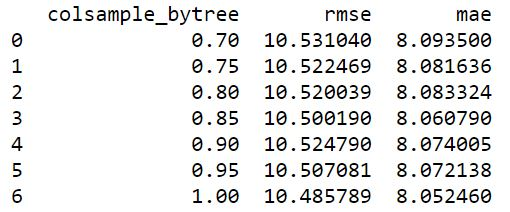

In [528]:
#print(colsample_df)
Image(filename = "Colsample_bytree_ozone.jpg", width=300, height=270)

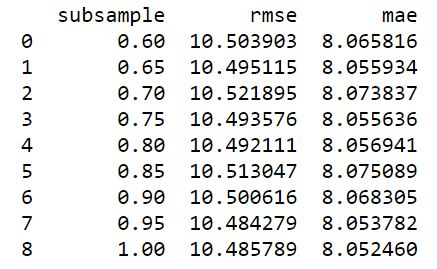

In [529]:
#print(subsample_df)
Image(filename = "Subsample_ozone.jpg", width=300, height=270)

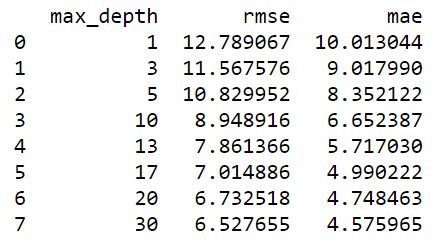

In [530]:
#print(depth_df)
Image(filename = "Maxdepth_ozone.jpg", width=300, height=270)

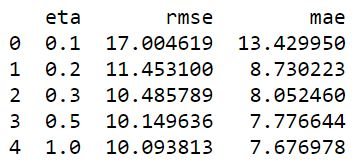

In [531]:
#print(eta_df)
Image(filename = "Eta_ozone.jpg", width=300, height=270)

In [532]:
### cross val, rmse and mae
tree_para_ozone = {'objective':'reg:squarederror','booster':'gbtree', 
             'n_estimators':1000, 'max_depth':20, 
             'colsample_bytree':1, 'subsample':1, 'eta':1}
nfold=10
boost=79

rmse_cv = xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_ozone=rmse_cv['test-rmse-mean'].tail().values[-1]
mae_cv= xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_ozone=mae_cv['test-mae-mean'].tail().values[-1]

[14:01:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [533]:
### save records
aqh_models=pd.DataFrame()
ozone_rows=pd.DataFrame(data={'Model': 'Ozone', 
                               'MAE':round(mae_ozone,2), 
                               'RMSE':round(rmse_ozone,2)}, index=[0])                             
aqh_models=aqh_models.append(ozone_rows)

In [534]:
print('Ozone model MAE',round(mae_ozone,2), 'and RMSE', round(rmse_ozone,2))

Ozone model MAE 5.79 and RMSE 8.06


Searching the right parameters for the ozone datasets using xgb.cv suggests:
- the higher the number of boosting rounds, the better. Because of the computing time, I'll go with 79. 
- all features and observations should be used for modeling (colsample_bytree & subsample =1)
- the max_depth gets optimum around 20.
- with all these parameters set, the best learning rate (eta) is 0.3.

The cross validation of the ozone model shows excellent results with a MAE of 5.8 ug/m3 and a RMSE of 8.1. The MAE is within the expected error measurement from common outdoor sensors which is typically 5 to 10 ug/m3.

[14:05:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Ozone model MAE 5.79 and RMSE 8.06


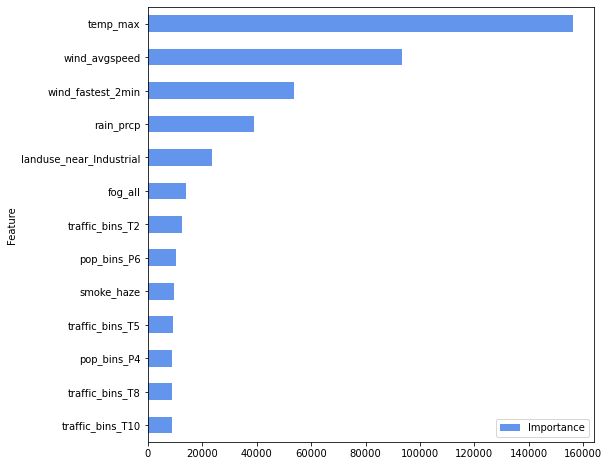

In [535]:
# Plot the feature importances
xgb_final_ozone = xgb.train(dtrain=ozone_dmx, params=tree_para_ozone , num_boost_round=100)
features_ozone = xgb_final_ozone.get_fscore()
impfeat_ozone = pd.DataFrame({'Importance': list(features_ozone.values()), 'Feature': list(features_ozone.keys())})
impfeat_ozone.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_ozone.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('Ozone model MAE',round(mae_ozone,2), 'and RMSE', round(rmse_ozone,2))

The major features of importance of the ozone model are not surprising:
- the first feature is the maximum temperature, which is a catalyst in the formation of ozone.
- the second and third features are the wind, which transports the ozone away from its source and  is the reason why ozone can be found in remote country areas.
- the fourth feature is the amount of rain precipitation, which is interesting because rainy days tend to be less polluted because the pollutants are washed away by the rain. This phenomenon is called 'wet deposition'. Here the influence of rain will have to be determined: is it washing away pollution or washing it in?
- the fifth feature is industrial activity. Note that the pollution is not in the industrial zone, but 'near' it, which story works well with the influence of the  wind and the rain on ozone formation.

The minor features are a mix of foggy/hazy weather, traffic and population.

I performed the same type of parameters search for the other five pollutants and came up with the following parameters and results:

In [536]:
### co
tree_para_co = {'objective':'reg:squarederror','booster':'gbtree', 'colsample_bytree':1,
               'subsample':1, 'max_depth':11, 'eta':0.3,
               'n_estimators':1000}
nfold=10
boost=79

rmse_cv_co = xgb.cv(dtrain=co_dmx, params=tree_para_co , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_co=rmse_cv_co['test-rmse-mean'].tail().values[-1]
mae_cv_co= xgb.cv(dtrain=co_dmx, params= tree_para_co , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_co=mae_cv_co['test-mae-mean'].tail().values[-1]

[14:05:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [537]:
### save records
co_rows=pd.DataFrame(data={'Model': 'CO', 
                               'MAE':round(mae_co,2), 
                               'RMSE':round(rmse_co,2)}, index=[0])                             
aqh_models=aqh_models.append(co_rows)

[14:05:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CO model MAE 0.1 and RMSE 0.16


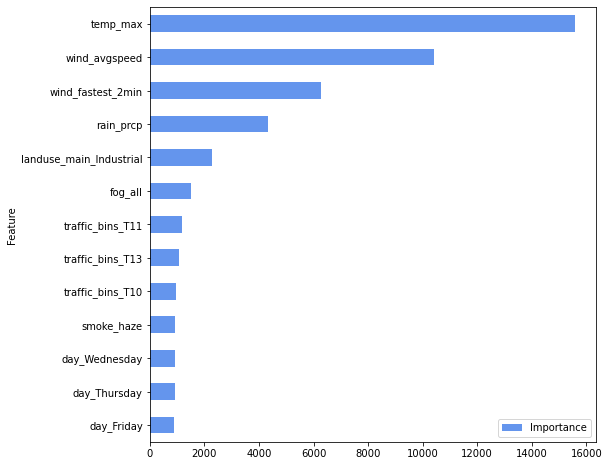

In [538]:
# Plot the feature importances
xgb_final_co = xgb.train(dtrain=co_dmx, params=tree_para_co , num_boost_round=100)
features_co = xgb_final_co.get_fscore()
impfeat_co = pd.DataFrame({'Importance': list(features_co.values()), 'Feature': list(features_co.keys())})
impfeat_co.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_co.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')

print('CO model MAE',round(mae_co,2), 'and RMSE', round(rmse_co,2))

In [539]:
### no2
tree_para_no2 = {'objective':'reg:squarederror','booster':'gbtree', 'colsample_bytree':0.95,
                'subsample':1, 'max_depth':13, 'eta':0.5,
                'n_estimator':1000}
nfold=10
boost=79

rmse_cv_no2 = xgb.cv(dtrain=no2_dmx, params=tree_para_no2 , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_no2=rmse_cv_no2['test-rmse-mean'].tail().values[-1]
mae_cv_no2= xgb.cv(dtrain=no2_dmx, params=tree_para_no2 , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_no2=mae_cv_no2['test-mae-mean'].tail().values[-1]

[14:05:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langu

In [540]:
### save records
no2_rows=pd.DataFrame(data={'Model': 'NO2', 
                               'MAE':round(mae_no2,2), 
                               'RMSE':round(rmse_no2,2)}, index=[0])                             
aqh_models=aqh_models.append(no2_rows)

[14:07:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


NO2 model MAE 5.15 and RMSE 7.0


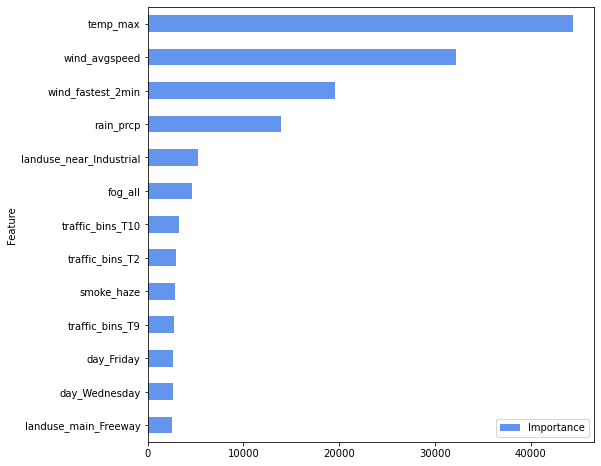

In [541]:
# Plot the feature importances
xgb_final_no2 = xgb.train(dtrain=no2_dmx, params=tree_para_no2 , num_boost_round=100)
features_no2 = xgb_final_no2.get_fscore()
impfeat_no2 = pd.DataFrame({'Importance': list(features_no2.values()), 'Feature': list(features_no2.keys())})
impfeat_no2.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_no2.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('NO2 model MAE',round(mae_no2,2), 'and RMSE', round(rmse_no2,2))

In [542]:
### so2
tree_para_so2 = {'objective':'reg:squarederror','booster':'gbtree', 'colsample_bytree':1,
            'subsample':1, 'max_depth':9, 'eta':0.1,
            'n_estimators':1000}
nfold=10
boost=79

rmse_cv_so2 = xgb.cv(dtrain=so2_dmx, params=tree_para_so2 , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_so2=rmse_cv_so2['test-rmse-mean'].tail().values[-1]
mae_cv_so2= xgb.cv(dtrain=so2_dmx, params=tree_para_so2 , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_so2=mae_cv_so2['test-mae-mean'].tail().values[-1]

[14:08:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [543]:
### save records
so2_rows=pd.DataFrame(data={'Model': 'SO2', 
                               'MAE':round(mae_so2,2), 
                               'RMSE':round(rmse_so2,2)}, index=[0])                             
aqh_models=aqh_models.append(so2_rows)

[14:08:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


SO2 model MAE 2.49 and RMSE 4.86


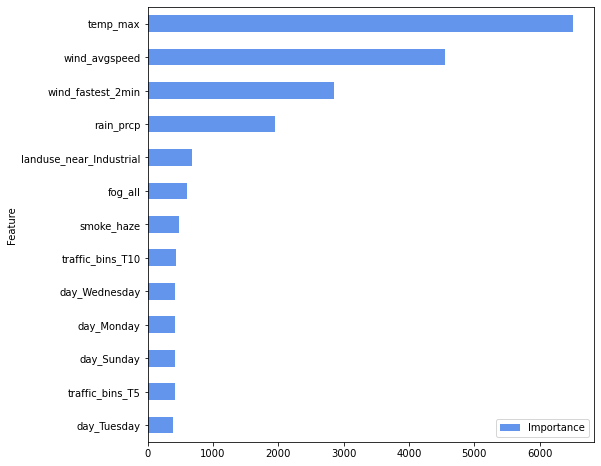

In [544]:
# Plot the feature importances
xgb_final_so2 = xgb.train(dtrain=so2_dmx, params=tree_para_so2 , num_boost_round=100)
features_so2 = xgb_final_so2.get_fscore()
impfeat_so2 = pd.DataFrame({'Importance': list(features_so2.values()), 'Feature': list(features_so2.keys())})
impfeat_so2.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_so2.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('SO2 model MAE', round(mae_so2,2), 'and RMSE', round(rmse_so2,2))

In [545]:
### pm25
tree_para_pm25 = {'objective':'reg:squarederror','booster':'gbtree', 'colsample_bytree':1,
            'subsample':0.9, 'max_depth':20, 'eta':0.3,
            'n_estimators':1000}
nfold=10
boost=79

rmse_cv_pm25 = xgb.cv(dtrain=pm25_dmx, params=tree_para_pm25 , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_pm25=rmse_cv_pm25['test-rmse-mean'].tail().values[-1]
mae_cv_pm25= xgb.cv(dtrain=pm25_dmx, params=tree_para_pm25 , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_pm25=mae_cv_pm25['test-mae-mean'].tail().values[-1]

[14:08:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [546]:
### save records
pm25_rows=pd.DataFrame(data={'Model': 'PM 2.5', 
                               'MAE':round(mae_pm25,2), 
                               'RMSE':round(rmse_pm25,2)}, index=[0])                             
aqh_models=aqh_models.append(pm25_rows)

[14:11:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


PM 2.5 model MAE 1.79 and RMSE 2.64


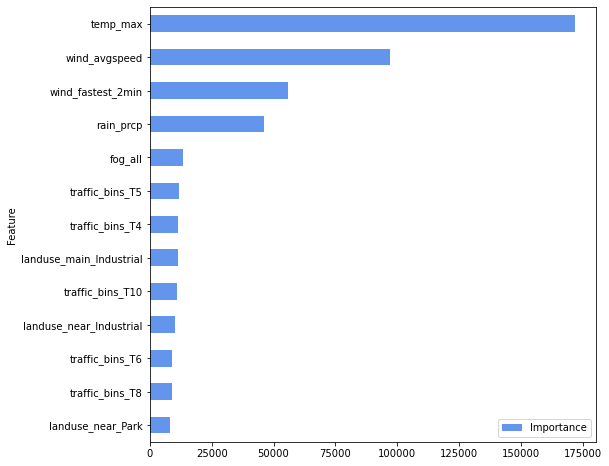

In [547]:
# Plot the feature importances
xgb_final_pm25 = xgb.train(dtrain=pm25_dmx, params= tree_para_pm25 , num_boost_round=100)
features_pm25 = xgb_final_pm25.get_fscore()
impfeat_pm25 = pd.DataFrame({'Importance': list(features_pm25.values()), 'Feature': list(features_pm25.keys())})
impfeat_pm25.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_pm25.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('PM 2.5 model MAE', round(mae_pm25,2), 'and RMSE', round(rmse_pm25,2))

In [548]:
### pm10
tree_para_pm10 = {'objective':'reg:squarederror','booster':'gbtree', 'colsample_bytree':0.95,
            'subsample':1, 'max_depth':20, 'eta':0.3,
            'n_estimators':1000}
nfold=10
boost=79

rmse_cv_pm10 = xgb.cv(dtrain=pm10_dmx, params=tree_para_pm10 , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_pm10=rmse_cv_pm10['test-rmse-mean'].tail().values[-1]
mae_cv_pm10= xgb.cv(dtrain=pm10_dmx, params=tree_para_pm10 , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_pm10=mae_cv_pm10['test-mae-mean'].tail().values[-1]

[14:12:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:12:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:12:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

In [549]:
### save records
pm10_rows=pd.DataFrame(data={'Model': 'PM 10', 
                               'MAE':round(mae_pm10,2), 
                               'RMSE':round(rmse_pm10,2)}, index=[0])                             
aqh_models=aqh_models.append(pm10_rows)

[14:12:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


PM 10 model MAE 5.52 and RMSE 9.24


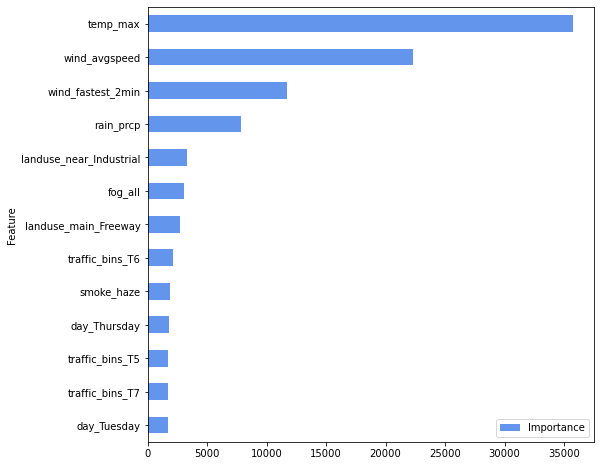

In [550]:
# Plot the feature importances
xgb_final_pm10 = xgb.train(dtrain=pm10_dmx, params= tree_para_pm10 , num_boost_round=100)
features_pm10 = xgb_final_pm10.get_fscore()
impfeat_pm10 = pd.DataFrame({'Importance': list(features_pm10.values()), 'Feature': list(features_pm10.keys())})
impfeat_pm10.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_pm10.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('PM 10 model MAE', round(mae_pm10,2), 'and RMSE', round(rmse_pm10,2))

In [551]:
aqh_models

,Model,MAE,RMSE
0,Ozone,5.79,8.06
0,CO,0.10,0.16
0,NO2,5.15,7.00
0,SO2,2.49,4.86
0,PM 2.5,1.79,2.64
0,PM 10,5.52,9.24


The MAE and RMSE values of the tuned models are satisfactory besides for CO for which most of the data falls around 0.3 and therefore a MAE of 0.1 is far from ideal.
Interestingly for all models the top four major features are the same (in order):
- maximum temperature
- wind (average and fastest 2 minutes)
- rain precipitation

The 'Land Use (near/main) Industrial' and 'Fog' follow besides for PM 2.5 where the influence of industrial activity is much lower ranked.

The minor features vary:
- for ozone: smoke/haze, moderate population growth (1-2%) and low to high traffic (100k to 1.2M cars per year).
- for CO: smoke/haze, high to very high traffic (1.2M to 4M cars per year), and bad days are Wednesday, Thursday and Friday.
- for NO2: smoke/haze, low and high traffic (100k and 1.2M cars per year), bads days on Wednesday and Friday and vicinity to freeway.
- for SO2: smoke/haze. moderate to high traffic (500k to 1.2M cars per year),and bad days on Sunday, Monday, Tuesday and Wednesday.
- for PM 2.5: moderate to high traffic (500k to 1.2M cars per year), and vicinity to industrial acitivty or to parks.
- for PM 10: vicinity to freeway, smoke/haze, moderate trafiic (between 100k and 1M cars per year) and bad days on Tuesday and Thursday.

<a class="anchor" id="section4_3"></a>
## 4.3. Ozone Formation
As XGBoost is performing well with the datasets, I thought why not predicting the formation of ozone based on the other pollutants?
Ozone is formed by the combination of VOx and NOx and is catalyzed by heat and light. As NO2 is part of the NOx, I'll try to model the formation of ozone from NO2 (feat_ozno2 dataframe) and as the data is available why not trying to model the formation of ozone using all other pollutants (feat_fivepoll dataframe).

In [588]:
### create DMatrix
X_ozno2, y_ozno2, X_ozno2_train, X_ozno2_test, y_ozno2_train, y_ozno2_test=TTS(feat_ozno2poll,'ozone')
ozno2_dmx=xgb.DMatrix(data=X_ozno2, label=y_ozno2)
X_fivepoll, y_fivepoll, X_fivepoll_train, X_fivepoll_test, y_fivepoll_train, y_fivepoll_test=TTS(feat_fivepoll,'ozone')
fivepoll_dmx=xgb.DMatrix(data=X_fivepoll, label=y_fivepoll)

In [589]:
#### ozno2 - ozone formation  from NO2
tree_para_ozno2 = {'objective':'reg:squarederror','booster':'gbtree',
                   'colsample_bytree':1, 'subsample':1, 'max_depth':20, 'eta':0.3,
                   'n_estimators':1000}                  
nfold=10
boost=79

rmse_cv_ozno2 = xgb.cv(dtrain=ozno2_dmx, params=tree_para_ozno2 , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_ozno2=rmse_cv_ozno2['test-rmse-mean'].tail().values[-1]
mae_cv_ozno2= xgb.cv(dtrain=ozno2_dmx, params=tree_para_ozno2 , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_ozno2=mae_cv_ozno2['test-mae-mean'].tail().values[-1]

[14:24:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

[14:35:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Ozone/NO2 model MAE 5.89 and RMSE 8.16


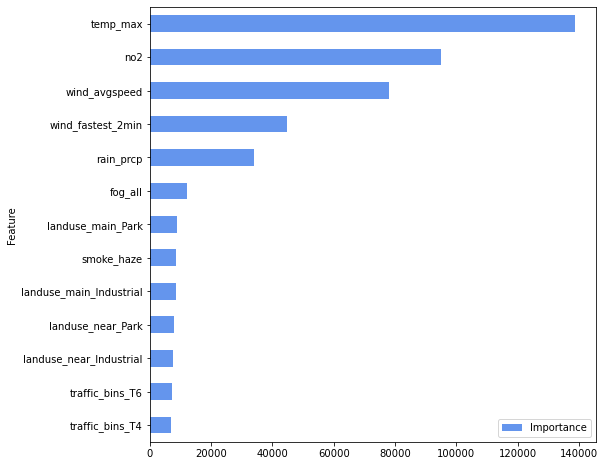

In [595]:
# Plot the feature importances
xgb_final_ozno2 = xgb.train(dtrain=ozno2_dmx, params=tree_para_ozno2 , num_boost_round=100)
features_ozno2 = xgb_final_ozno2.get_fscore()
impfeat_ozno2 = pd.DataFrame({'Importance': list(features_ozno2.values()), 'Feature': list(features_ozno2.keys())})
impfeat_ozno2.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_ozno2.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('Ozone/NO2 model MAE',round(mae_ozno2,2), 'and RMSE', round(rmse_ozno2,2))

In [593]:
### fivepoll- ozone formation using the four other pollutants
tree_para_fivepoll = {'objective':'reg:squarederror','booster':'gbtree',
             'colsample_bytree':1, 'subsample':1, 'max_depth':21, 'eta':0.5,
             'n_estimators':1000}
nfold=10
boost=79

rmse_cv_fivepoll = xgb.cv(dtrain=fivepoll_dmx, params=tree_para_fivepoll , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_fivepoll=rmse_cv_fivepoll['test-rmse-mean'].tail().values[-1]
mae_cv_fivepoll= xgb.cv(dtrain=fivepoll_dmx, params=tree_para_fivepoll , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_fivepoll=mae_cv_fivepoll['test-mae-mean'].tail().values[-1]

[14:27:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

[14:36:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Ozone/4 pollutants model MAE 2.15 and RMSE 4.55


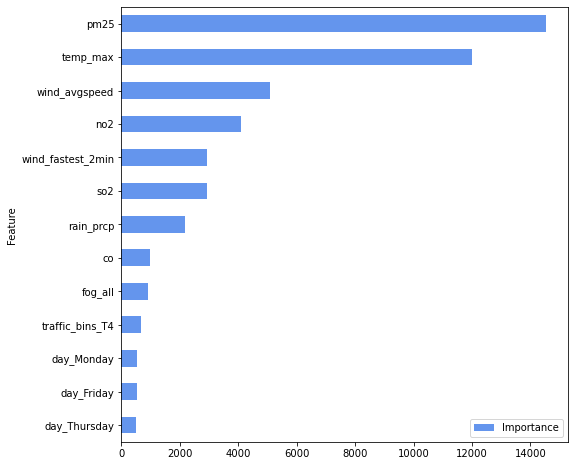

In [596]:
# Plot the feature importances
xgb_final_fivepoll = xgb.train(dtrain=fivepoll_dmx, params=tree_para_fivepoll , num_boost_round=100)
features_fivepoll = xgb_final_fivepoll.get_fscore()
impfeat_fivepoll = pd.DataFrame({'Importance': list(features_fivepoll.values()), 'Feature': list(features_fivepoll.keys())})
impfeat_fivepoll.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_fivepoll.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
print('Ozone/4 pollutants model MAE', round(mae_fivepoll,2), 'and RMSE', round(rmse_fivepoll,2))

The XGBoost Regressor performs better when predicting the formation of ozone from 5 pollutants (CO, NO2, SO2, PM 2.5, and PM 10- MAE=2.2, RMSE=4.6) than from 1 pollutant (NO2 - MAE=5.9, RMSE=8.2).
The main features driving ozone formation are:
- the pollutants PM 2.5 and NO2.
- daily maximum temperature and wind.
- then comes rain and pollutant SO2.

These two last models show that ozone formation can be modelled using different pollutant emissions scenarios.

<a class="anchor" id="section4_4"></a>
## 4.4. Conclusion
The main question raised for this project was 'What will be the air quality in Houston in 2028 taking into account increasing population growth and traffic congestion?"... It turns out population and traffic do not seem to be the main problem. It seems the main source is out of the picture, not in this dataset. We can see only the influence of the drivers (temperature, wind, rain) that distribute the pollutants around town. We can see how the main pollutants relate to the formation of ozone. But what is missing is the actual source of the pollution: industrial emissions.
The next step, data story telling, is not going to be a story about a growing city with a thriving population. It is going to about a city which is sickening.